## Imports

In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
from fastai2.basics import *
from fastai2.vision.augment import *
from fastai2.vision.core import *
from fastai2.vision.data import *
from fastai2.vision.all import *
from fastai2.data.all import *
from src.multichannel import *
from src.customnets import SimpleNet
import geopandas as gpd
from itertools import permutations, product
from torch.autograd import Variable
from torch.optim import SGD
from copy import deepcopy
from src.spectral_variables import *
plt.style.use('seaborn-paper')

In [3]:
atm_cor_bw_dict = {int(round(used_bands[i],0)): i for i in range(len(used_bands))}

# Load model and data

In [4]:
learn_path = Path('fastai_models/2m_relu_fixed/')
tile_path = Path('data/tiles')
shape_path = Path('data/labeled_tiles_fixed//labeled_tiles/')
data_path = Path('data/tree_cubes_10m_fixed/2m')
stats = np.load(str(data_path/'train_stats.npy'))
test_trees = gpd.read_file(str(data_path/'test.shp'))
train_trees = gpd.read_file(str(data_path/'train.shp'))

In [5]:
learn = load_learner(learn_path/'export.pkl', cpu=False)

In [6]:
test_dl = learn.dls.test_dl(test_trees, with_labels=True, bs=1)


In [7]:
test_interp = ClassificationInterpretation.from_learner(learn, dl=test_dl)
test_interp.print_classification_report()

/projappl/project_2001325/miniconda3/envs/ibc-carbon/lib/python3.7/site-packages/torch/nn/functional.py:2764: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "
/projappl/project_2001325/miniconda3/envs/ibc-carbon/lib/python3.7/site-packages/torch/nn/functional.py:2705: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "


                precision    recall  f1-score   support

         Birch       0.71      0.84      0.77        73
European aspen       0.94      0.88      0.91        82
 Norway spruce       0.92      0.83      0.87       207
    Scots pine       0.87      0.93      0.90       168

      accuracy                           0.87       530
     macro avg       0.86      0.87      0.86       530
  weighted avg       0.88      0.87      0.87       530



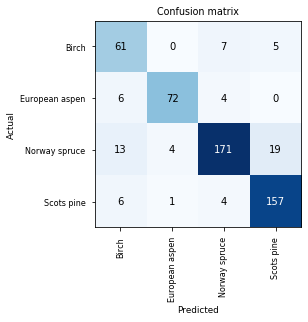

In [8]:
test_interp.plot_confusion_matrix()

In [9]:
test_preds = learn.get_preds(with_decoded=True, dl=test_dl, ds_idx=2, with_loss=False)

In [10]:
correct = test_dl.items.iloc[1].species
prediction = test_dl.vocab[test_preds[2][1]]
correct, prediction

('Scots pine', 'Norway spruce')

Note most important bands for SVM and RF, from Viinikka & Hurskainen (in progress):

In [11]:
svm_aspen = [541,544,721,547,717,714,711,1700,724,1695,1706,1689,727,506,1520]
svm_aspen_idx = [atm_cor_bw_dict[bw] for bw in svm_aspen if bw in atm_cor_bw_dict.keys()]

svm_birch = [714,506,711,717,721,724,544,708,547,473,541,1406,1531]
svm_birch_idx = [atm_cor_bw_dict[bw] for bw in svm_birch if bw in atm_cor_bw_dict.keys()]

svm_spruce = [705,1662,1667,708,683,1656,1711,727,1673,1717,1302,1307,1296,1291,1706]
svm_spruce_idx = [atm_cor_bw_dict[bw] for bw in svm_spruce if bw in atm_cor_bw_dict.keys()]

svm_pine = [705,1667,1662,1656,727,1307,1302,1293,683,1313,730,1291,733,708,1285]
svm_pine_idx = [atm_cor_bw_dict[bw] for bw in svm_pine if bw in atm_cor_bw_dict.keys()]

And same with RF

In [12]:
rf_aspen = [519,538,535,532,541,991,702,525,516,1477,699,528,1196,644]
rf_aspen_idx = [atm_cor_bw_dict[bw] for bw in rf_aspen if bw in atm_cor_bw_dict.keys()]

rf_birch = [538,532,528,541,522,519,55,544,513,509,503,500,442,439,430]
rf_birch_idx = [atm_cor_bw_dict[bw] for bw in rf_birch if bw in atm_cor_bw_dict.keys()]

rf_spruce = [557,541,522,1667,991,467,535,532,528,525,519,516,470,458]
rf_spruce_idx = [atm_cor_bw_dict[bw] for bw in rf_spruce if bw in atm_cor_bw_dict.keys()]

rf_pine = [991,708,705,702,557,541,467,470,458,408,401]
rf_pine_idx = [atm_cor_bw_dict[bw] for bw in rf_pine if bw in atm_cor_bw_dict.keys()]

# Saliencies with vanilla backpropagation

VanillaBackprop and GuidedBackprop are implemented from [PyTorch CNN Visualizations](https://github.com/utkuozbulak/pytorch-cnn-visualizations) by Utku Ozbulak.

From [Wikipedia](https://en.wikipedia.org/wiki/Saliency_map)

> In computer vision, a saliency map is an image that shows each pixel's unique quality. The goal of a saliency map is to simplify and/or change the representation of an image into something that is more meaningful and easier to analyze. For example, if a pixel has a high grey level or other unique color quality in a color image, that pixel's quality will show in the saliency map and in an obvious way. Saliency is a kind of image segmentation.

For CNNs, saliency maps specifically plot the gradient of the predicted outcome from the model with respect to the input, or pixel values.

$W$ is defined as gradient of the maximum predicted class score $S_c$ with respect to the input image $I_i$:

$$
W = \frac{\delta S_c}{\delta I_i}
$$

First lets calculate them with vanilla backpropagation. Backpropagation is the algorithm for computing the gradient for deep learning, more in [https://en.wikipedia.org/wiki/Backpropagation](https://en.wikipedia.org/wiki/Backpropagation).

In [13]:
# TODO move to separate scripts

class VanillaBackprop():
    """
        Produces gradients generated with vanilla back propagation from the image
    """
    def __init__(self, model):
        self.model = model
        self.gradients = None
        # Put model in evaluation mode
        self.model.eval()
        # Hook the first layer to get the gradient
        self.hook_layers()
        
    def hook_layers(self):
        def hook_function(module, grad_in, grad_out):
            self.gradients = grad_in[0]

        # Register hook to the first layer -> input
        first_layer = list(self.model.features._modules.items())[0][1][0]
        first_layer.register_backward_hook(hook_function)

    def generate_gradients(self, input_image, target_class):
        # Forward
        model_output = self.model(input_image)
        # Zero grads
        self.model.zero_grad()
        # Target for backprop
        one_hot_output = torch.FloatTensor(1, model_output.size()[-1]).zero_().cuda()
        
        # Target should be maximum predicted class score
        target_class = model_output.argmax().item()
        one_hot_output[0][target_class] = 1
        # Backward pass
        model_output.backward(gradient=one_hot_output)
        # Convert Pytorch variable to numpy array
        gradients_as_arr = self.gradients.data.cpu().numpy()[0]
        return gradients_as_arr

In [14]:
vbp = VanillaBackprop(deepcopy(learn.model))
saliences =[[],[],[],[]]
valids = [[],[],[],[]]
corrects = [[],[],[],[]]
all_saliences = []
all_valids = []
m = learn.model.eval()
for inputs, targets in test_dl:
    res = m(inputs).argmax().item()
    vanilla_grads = vbp.generate_gradients(Variable(inputs, requires_grad=True), targets)
    saliences[res].append(vanilla_grads[0])
    valids[res].append(inputs)
    corrects[res].append(targets.item())
    all_saliences.append(vanilla_grads[0])
    all_valids.append(inputs)

Nagasubramanian et al. (2019) calculate the following: 

Most important wavelength:

$$
C^* = argmax_{C \in(1,2,...250)} |W_{C,x,y}| \quad for(x,y) \in I_i
$$

and L1-norm histogram:

Calculate L1-norm so that

$$
G_i = \sum_x \sum_y | W_{C,x,y)} | \quad for (x,y) \in I_i
$$

Recall that L1-norm is just

$$
||X||_1 = \sum |x_i|
$$

And histogram (for aspen) is then

$$
G_{aspen} = \frac{\sum_{i \in aspen} G_i}{||\sum_{i \in aspen} G_i||_1}
$$

In [15]:
def calc_important_bands(saliences):
    band_list = []
    for i in range(len(saliences)):
        tree = saliences[i]
        for x,y in product(range(tree.shape[-2]), range(tree.shape[-1])):
            c_star = np.argmax(np.abs(tree[:,x,y]))
            band_list.append(c_star)
    max_bands = np.array(band_list)
    band_counts = []
    for i in range(saliences.shape[-3]):
        band_counts.append((len(max_bands[max_bands==i])))
    return np.array(band_counts) / np.sum(band_counts)

def calc_l1_norm(saliences):
    norm_list = []
    for i in range(len(saliences)):
        tree = saliences[i]
        # tree is 250,x,x -shaped cube
        g_i = 0
        for x, y in product(range(tree.shape[-2]),range(tree.shape[-1])):
            g_i += np.abs(tree[:,x,y])
        norm_list.append(g_i)
    norms = np.array(norm_list)
    return norms.sum(axis=(0)) / norms.sum(axis=0).sum()

In [16]:
aspen_saliences = np.array(saliences[1])
birch_saliences = np.array(saliences[0])
spruce_saliences = np.array(saliences[2])
pine_saliences = np.array(saliences[3])

First L1-histogram:

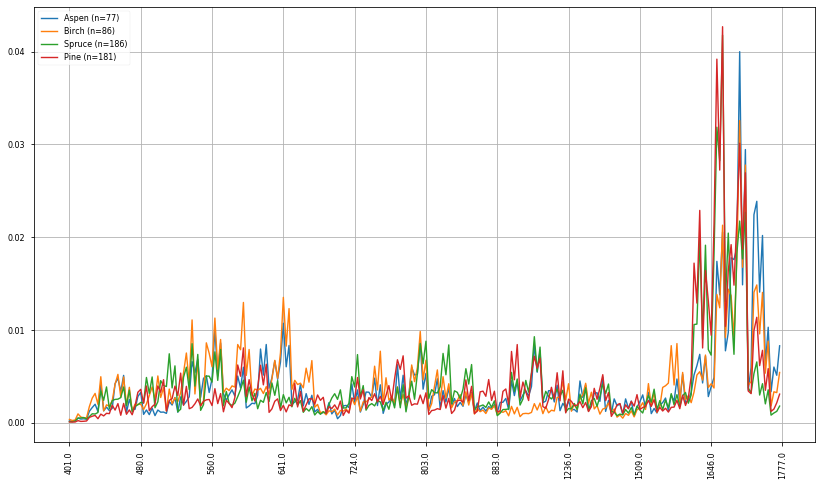

In [17]:
plt.figure(figsize=(14,8))
plt.plot(calc_l1_norm(aspen_saliences))
plt.plot(calc_l1_norm(birch_saliences))
plt.plot(calc_l1_norm(spruce_saliences))
plt.plot(calc_l1_norm(pine_saliences))
sel_bws = used_bands
labels = [round(sel_bws[i],0) for i in np.arange(0, len(sel_bws), step=25)]
labels.append(round(sel_bws[-1],0))

plt.xticks(np.arange(0, len(sel_bws)+1, step=25), labels, rotation='vertical')
plt.grid()
plt.legend([f'Aspen (n={aspen_saliences.shape[0]})', f'Birch (n={birch_saliences.shape[0]})', 
            f'Spruce (n={spruce_saliences.shape[0]})', f'Pine (n={pine_saliences.shape[0]})',
           ])

And then class-wise most important bands:

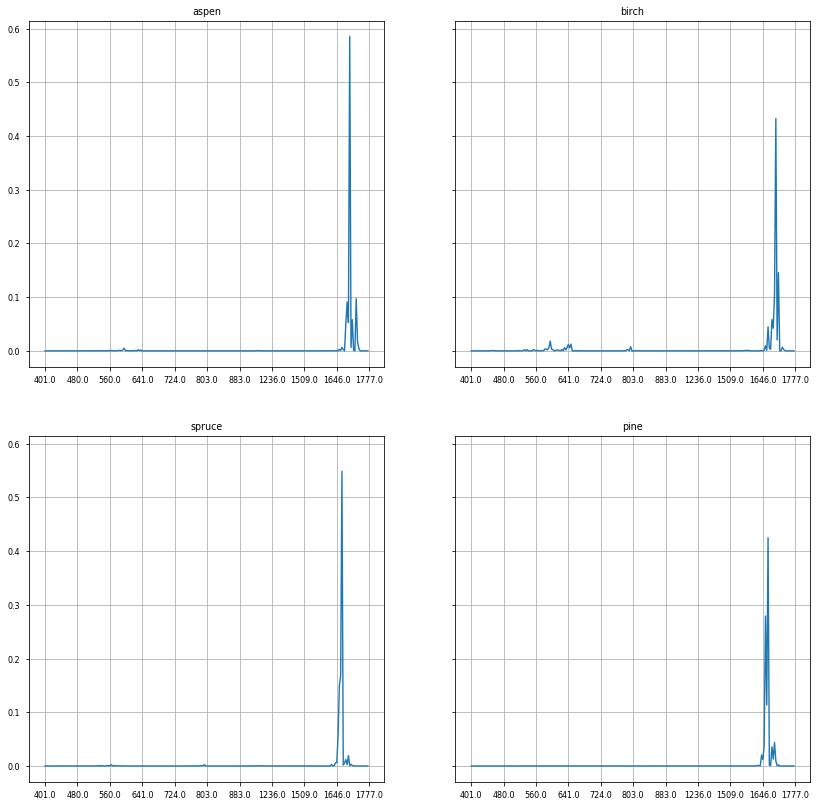

In [18]:
fig, axs = plt.subplots(2,2, figsize=(14,14), sharey=True)
for a in axs.flatten(): a.grid()
axs[0,0].plot(calc_important_bands(aspen_saliences))
axs[0,1].plot(calc_important_bands(birch_saliences))
axs[1,0].plot(calc_important_bands(spruce_saliences))
axs[1,1].plot(calc_important_bands(pine_saliences))
labels = [round(sel_bws[i],0) for i in np.arange(0, len(sel_bws), step=25)]
labels.append(round(sel_bws[-1], 0))
species = ['aspen', 'birch', 'spruce', 'pine']
for i, a in enumerate(axs.flatten()): a.set_title(species[i])
for a in axs.flatten():
    a.set_xticks(np.arange(0, len(sel_bws)+1, step=25))
    a.set_xticklabels(labels)

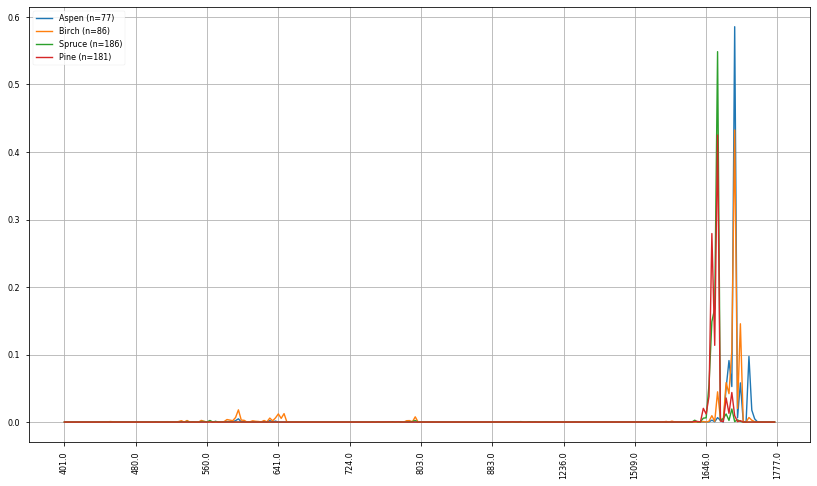

In [19]:
plt.figure(figsize=(14,8))
plt.plot(calc_important_bands(aspen_saliences))
plt.plot(calc_important_bands(birch_saliences))
plt.plot(calc_important_bands(spruce_saliences))
plt.plot(calc_important_bands(pine_saliences))
labels = [round(sel_bws[i],0) for i in np.arange(0, len(sel_bws), step=25)]
labels.append(round(sel_bws[-1],0))

plt.xticks(np.arange(0, len(sel_bws)+1, step=25), labels, rotation='vertical')
plt.grid()
plt.legend([f'Aspen (n={aspen_saliences.shape[0]})', f'Birch (n={birch_saliences.shape[0]})', 
            f'Spruce (n={spruce_saliences.shape[0]})', f'Pine (n={pine_saliences.shape[0]})',
           ])

Pölönen et al (2019) instead calculate mean saliencies:

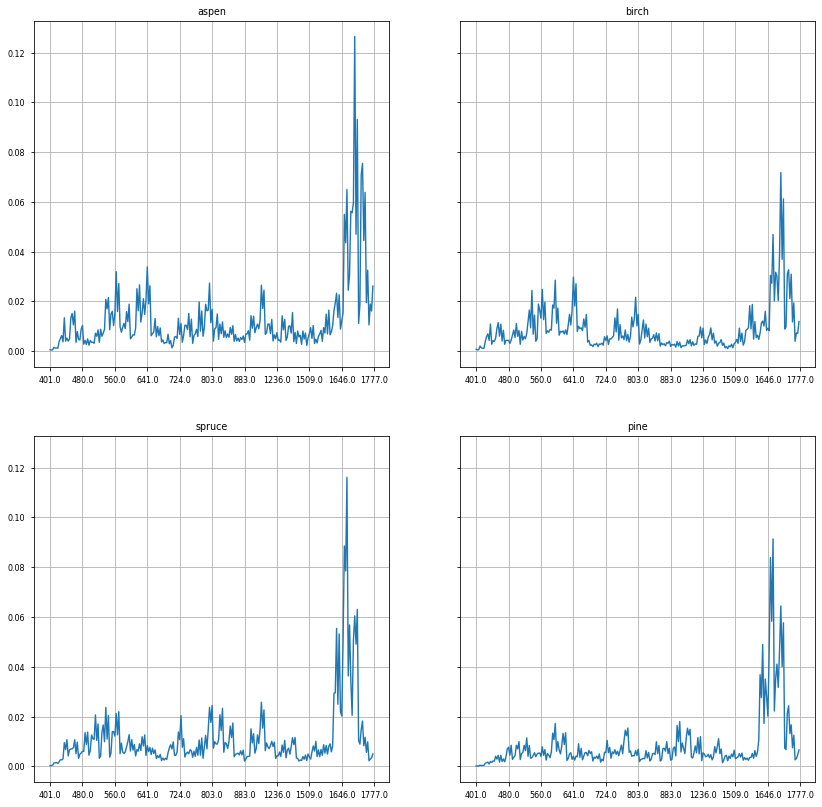

In [20]:
fig, axs = plt.subplots(2,2, figsize=(14,14), sharey=True)
for a in axs.flatten(): a.grid()
axs[0,0].plot(np.abs(aspen_saliences).mean(axis=(0,2,3)))
axs[0,1].plot(np.abs(birch_saliences).mean(axis=(0,2,3)))
axs[1,0].plot(np.abs(spruce_saliences).mean(axis=(0,2,3)))
axs[1,1].plot(np.abs(pine_saliences).mean(axis=(0,2,3)))
labels = [round(sel_bws[i],0) for i in np.arange(0, len(sel_bws), step=25)]
labels.append(round(sel_bws[-1], 0))
species = ['aspen', 'birch', 'spruce', 'pine']
for i, a in enumerate(axs.flatten()): a.set_title(species[i])
for a in axs.flatten():
    a.set_xticks(np.arange(0, len(sel_bws)+1, step=25))
    a.set_xticklabels(labels)

Match most important SVM (red) and RF (yellow) bands with average saliences

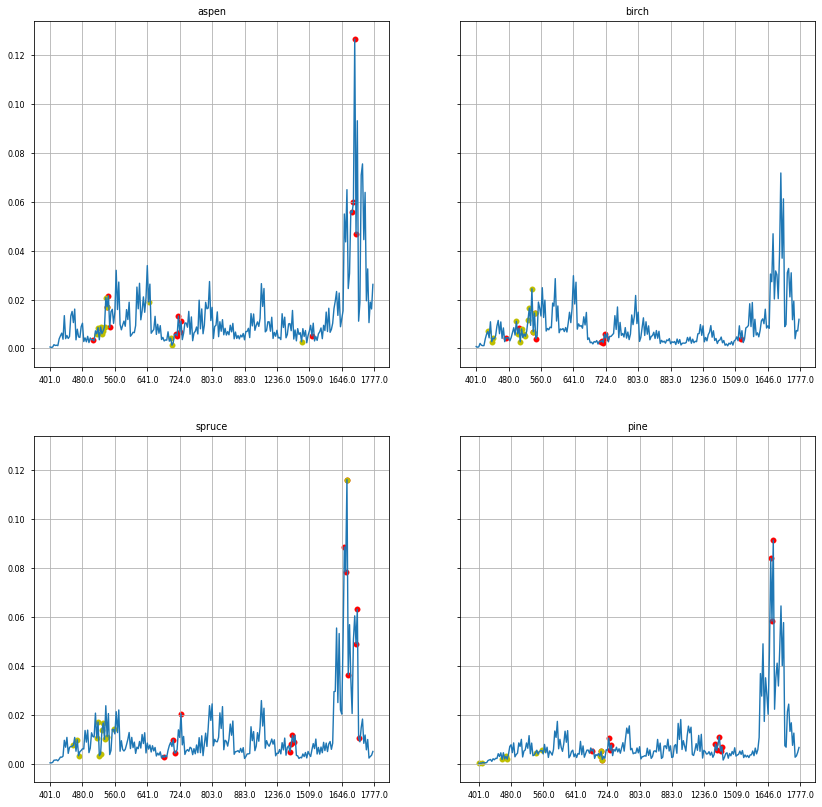

In [21]:
fig, axs = plt.subplots(2,2, figsize=(14,14), sharey=True)
for a in axs.flatten(): a.grid()
axs[0,0].plot(np.abs(aspen_saliences).mean(axis=(0,2,3)))
axs[0,0].scatter(svm_aspen_idx, [np.abs(aspen_saliences).mean(axis=(0,2,3))[i] for i in svm_aspen_idx], color='r')
axs[0,0].scatter(rf_aspen_idx, [np.abs(aspen_saliences).mean(axis=(0,2,3))[i] for i in rf_aspen_idx], color='y')

axs[0,1].plot(np.abs(birch_saliences).mean(axis=(0,2,3)))
axs[0,1].scatter(svm_birch_idx, [np.abs(birch_saliences).mean(axis=(0,2,3))[i] for i in svm_birch_idx], color='r')
axs[0,1].scatter(rf_birch_idx, [np.abs(birch_saliences).mean(axis=(0,2,3))[i] for i in rf_birch_idx], color='y')


axs[1,0].plot(np.abs(spruce_saliences).mean(axis=(0,2,3)))
axs[1,0].scatter(svm_spruce_idx, [np.abs(spruce_saliences).mean(axis=(0,2,3))[i] for i in svm_spruce_idx], color='r')
axs[1,0].scatter(rf_spruce_idx, [np.abs(spruce_saliences).mean(axis=(0,2,3))[i] for i in rf_spruce_idx], color='y')


axs[1,1].plot(np.abs(pine_saliences).mean(axis=(0,2,3)))
axs[1,1].scatter(svm_pine_idx, [np.abs(pine_saliences).mean(axis=(0,2,3))[i] for i in svm_pine_idx], color='r')
axs[1,1].scatter(rf_pine_idx, [np.abs(pine_saliences).mean(axis=(0,2,3))[i] for i in rf_pine_idx], color='y')

labels = [round(sel_bws[i],0) for i in np.arange(0, len(sel_bws), step=25)]
labels.append(round(sel_bws[-1], 0))
species = ['aspen', 'birch', 'spruce', 'pine']
for i, a in enumerate(axs.flatten()): a.set_title(species[i])
for a in axs.flatten():
    a.set_xticks(np.arange(0, len(sel_bws)+1, step=25))
    a.set_xticklabels(labels)

In [22]:
import matplotlib.patches as mpatches

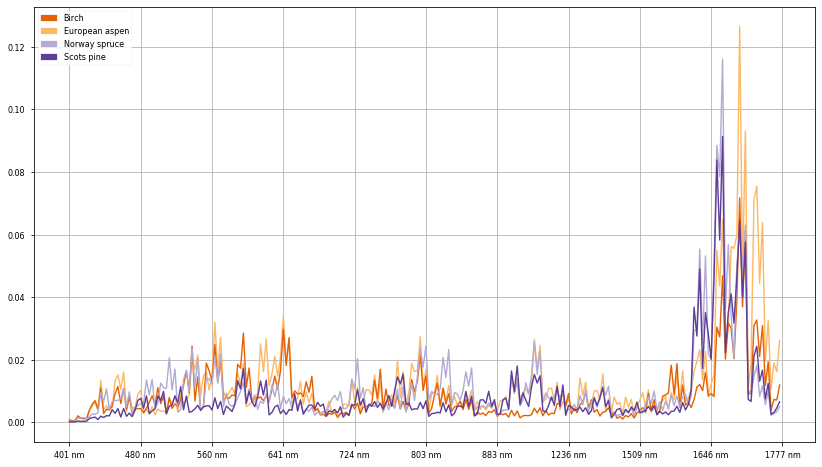

In [23]:
fig = plt.figure(figsize=(14,8))
plt.plot(np.abs(aspen_saliences).mean(axis=(0,2,3)), color="#fdb863")
plt.plot(np.abs(birch_saliences).mean(axis=(0,2,3)), color="#e66101")
plt.plot(np.abs(spruce_saliences).mean(axis=(0,2,3)), color="#b2abd2")
plt.plot(np.abs(pine_saliences).mean(axis=(0,2,3)), color="#5e3c99")
labels = [f'{int(round(sel_bws[i],0))} nm' for i in np.arange(0, len(sel_bws), step=25)]
labels.append(f'{int(round(sel_bws[-1],0))} nm')

plt.xticks(np.arange(0, len(sel_bws)+1, step=25), labels, rotation='horizontal')
plt.grid()
birch_patch = mpatches.Patch(color='#e66101', label='Birch')
aspen_patch = mpatches.Patch(color='#fdb863', label='European aspen')
spruce_patch = mpatches.Patch(color='#b2abd2', label='Norway spruce')
pine_patch = mpatches.Patch(color='#5e3c99', label='Scots pine')
plt.legend(handles=[birch_patch, aspen_patch, spruce_patch, pine_patch])

#plt.title('Average gradient magnitude for vanilla backpropagation')
plt.show()
#fig.savefig('vanilla_backprop_fixed.jpeg', dpi=500, bbox_inches='tight')

Plot average magnitude of the gradient in each spatial pixel

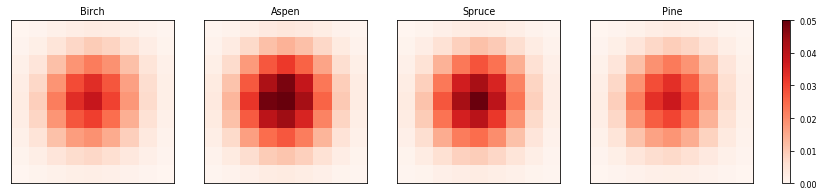

In [24]:
fig, axs = plt.subplots(1,5, figsize=(14,3), gridspec_kw={'width_ratios':[1,1,1,1,0.05]})
for a in axs[:-1].flatten():
    a.set_xticks([])
    a.set_yticks([])
    
vmin = 0
vmax = 0.05
im1 = axs[0].imshow(np.abs(birch_saliences).mean(axis=(0,1)), cmap='Reds', vmin=vmin, vmax=vmax)
axs[0].set_title('Birch')
axs[1].imshow(np.abs(aspen_saliences).mean(axis=(0,1)), cmap='Reds', vmin=vmin, vmax=vmax)
axs[1].set_title('Aspen')
axs[2].imshow(np.abs(spruce_saliences).mean(axis=(0,1)), cmap='Reds', vmin=vmin, vmax=vmax)
axs[2].set_title('Spruce')
axs[3].imshow(np.abs(pine_saliences).mean(axis=(0,1)), cmap='Reds', vmin=vmin, vmax=vmax)
axs[3].set_title('Pine')


cbar = fig.colorbar(im1, cax=axs[4])
#fig.savefig('spatial_vanilla_backprop_fixed.jpeg', dpi=500, bbox_inches='tight')

Check spatial location importances:

In [25]:
def convert_to_grayscale(saliences_for_img):
    gs_im = np.sum(np.abs(saliences_for_img), axis=0)
    im_max = np.percentile(gs_im, 100)
    im_min = np.min(gs_im)
    gs_im = (np.clip((gs_im - im_min) / (im_max-im_min),0,1))
    return gs_im

def take_max_grad(saliences_for_img):
    max_grads = np.abs(saliences_for_img).max(axis=0)
    return (max_grads - max_grads.min()) / (max_grads.max() - max_grads.min())

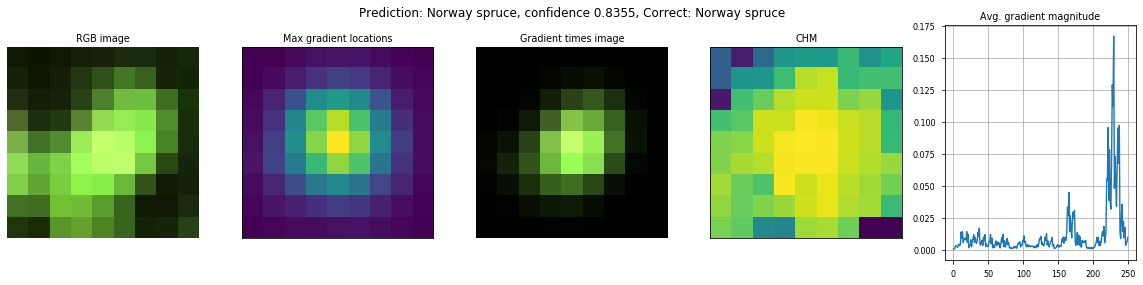

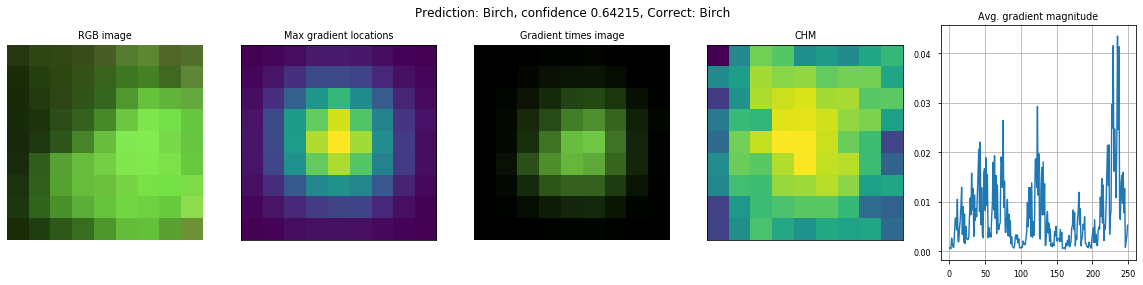

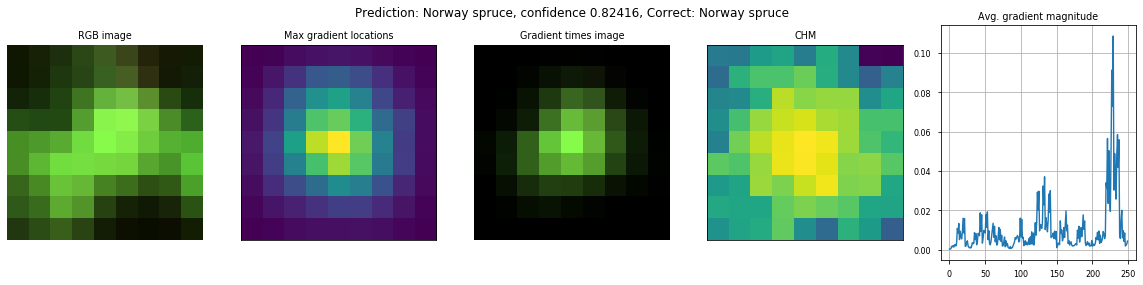

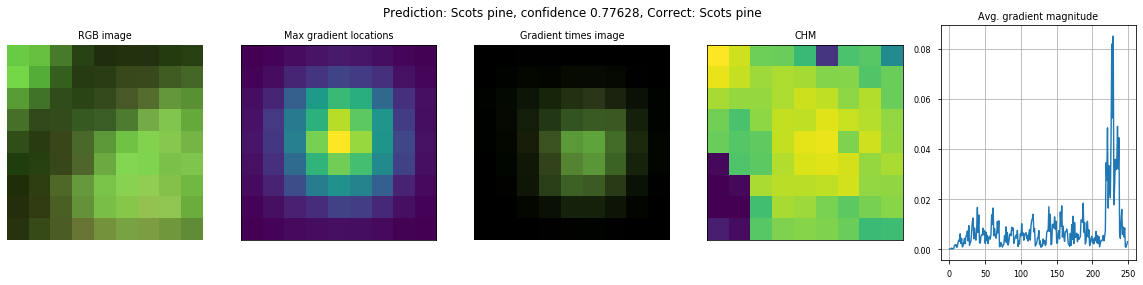

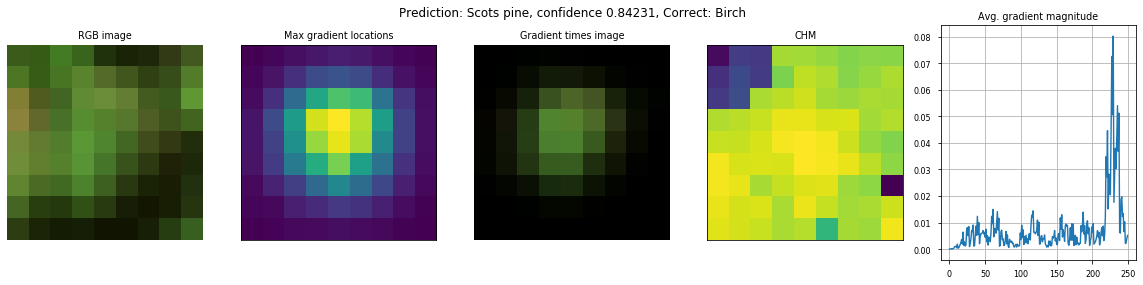

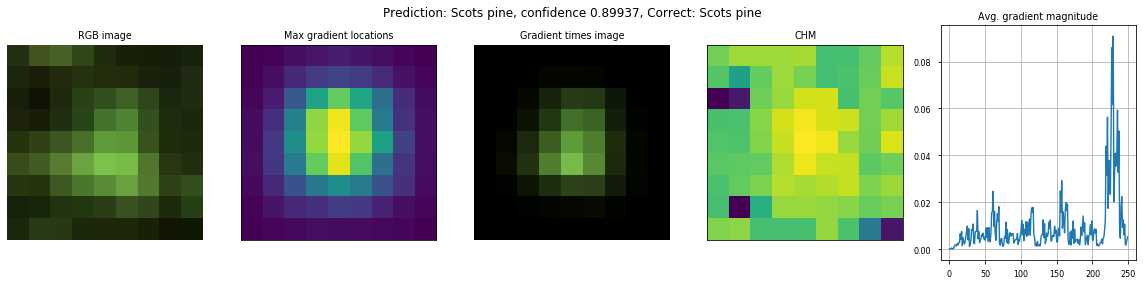

In [26]:
vmin, vmax = (0.05222363963723183, 5.074245080947874)

im_idx_list = np.random.randint(0, len(all_valids), 6)

for im_idx in im_idx_list:
    fig, axs = plt.subplots(1,5, figsize=(16,4))
    imvals = MultiChannelTensorImage(all_valids[im_idx][0][0].cpu()*(stats[1][used_band_idxs,None, None])
                                     + (stats[0][used_band_idxs,None, None]))

    imvals.show(channels=[82,50,29], scale=True, scale_axis=None, 
                vmin=vmin, vmax=vmax, ax=axs[0])
    for a in axs[:-1]:
        a.set_xticks([])
        a.set_yticks([])
    axs[0].set_title('RGB image')
    axs[1].imshow(take_max_grad(all_saliences[im_idx]), vmin=0, vmax=1)
    axs[1].set_title('Max gradient locations')
    grad_times_image = MultiChannelTensorImage((all_valids[im_idx][0][0].cpu()*stats[1][used_band_idxs,None, None] 
                                                + stats[0][used_band_idxs,None, None]) 
                                               * take_max_grad(all_saliences[im_idx]))
    grad_times_image.show(channels=[82,50,29], scale=True, scale_axis=None, 
                          vmin=vmin, vmax=vmax, ax=axs[2])
    axs[2].set_title('Gradient times image')
    chm = np.load(str(data_path/test_dl.items.iloc[im_idx].filename))[-1]
    axs[3].imshow(chm / chm.max())
    axs[3].set_title('CHM')
    
    axs[4].plot(np.abs(all_saliences[im_idx]).mean(axis=(-2,-1)))
    axs[4].grid(True)
    axs[4].set_title('Avg. gradient magnitude')
    correct = test_dl.items.iloc[im_idx].species
    prediction = test_dl.vocab[test_preds[2][im_idx]]
    plt.tight_layout()
    plt.suptitle(f'Prediction: {prediction}, confidence {round(test_preds[0][im_idx].max().item(), 5)}, Correct: {correct}')

And let's look at the magnitude of the gradient for each spectral channel of last image separately.

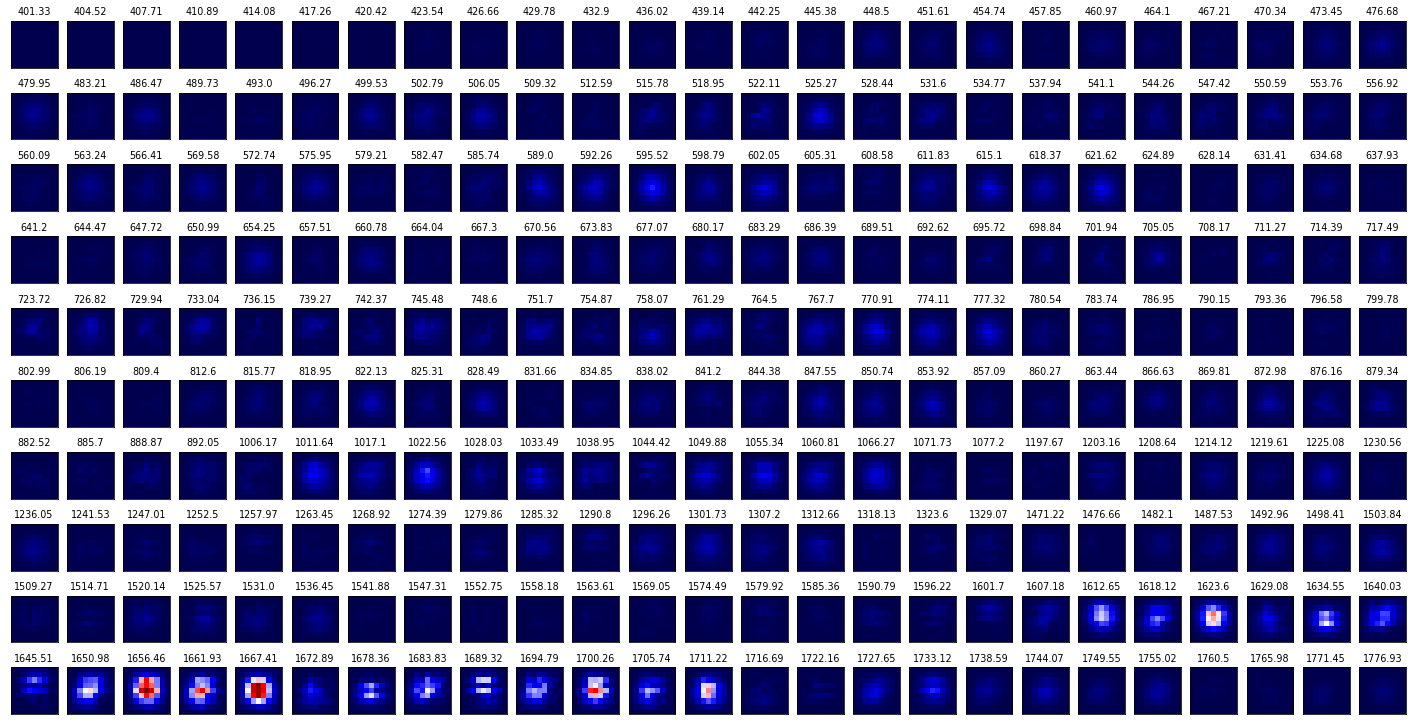

In [27]:
fig, axs = plt.subplots(10,25, figsize=(25,13))
for a in axs.flatten():
    a.set_xticks([])
    a.set_yticks([])
    
for i, ax in enumerate(axs.flatten()):
    ax.imshow(np.abs(all_saliences[im_idx][i]), vmin=0, vmax=np.abs(all_saliences[im_idx]).max(), cmap='seismic')
    ax.set_title(round(sel_bws[i], 2))


Here without taking the absolute value, but rather checking positive and negative input separately.

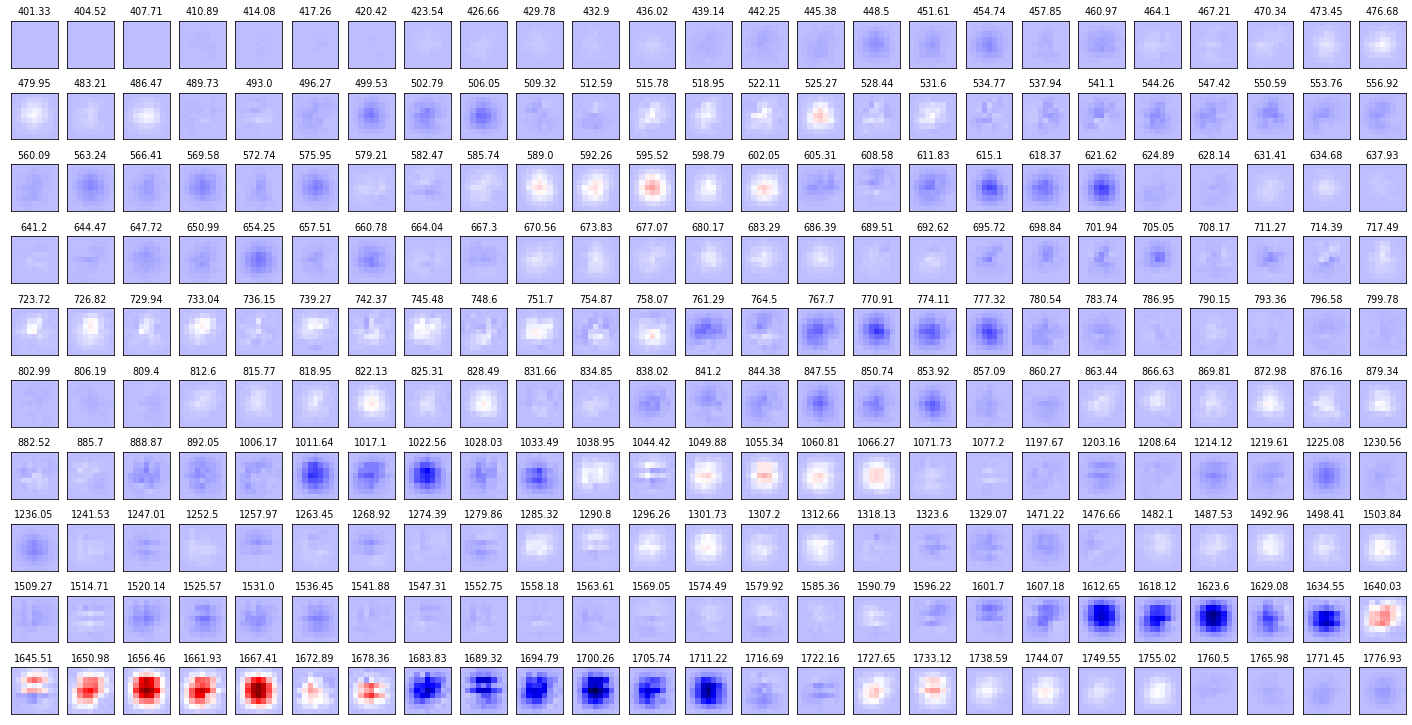

In [28]:
fig, axs = plt.subplots(10,25, figsize=(25,13))
for a in axs.flatten():
    a.set_xticks([])
    a.set_yticks([])
    
for i, ax in enumerate(axs.flatten()):
    ax.imshow((all_saliences[im_idx][i]), vmin=all_saliences[im_idx].min(), vmax=all_saliences[im_idx].max(), cmap='seismic')
    ax.set_title(round(sel_bws[i], 2))


# Saliences with guided backpropagation

Another way to compute saliences is to use so-called guided backpropagation, where all all negative gradients are replaced with zero in activation functions.

From [https://www.cs.toronto.edu/~guerzhoy/321/lec/W07/HowConvNetsSee.pdf](https://www.cs.toronto.edu/~guerzhoy/321/lec/W07/HowConvNetsSee.pdf):

> * Idea: neurons act like detectors of particular image features
> * We are only interested in what image features the neuron detects, not in what kind of stuff it *doesn't* detect.

In [29]:
class GuidedBackprop():
    """
       Produces gradients generated with guided back propagation from the given image
    """
    def __init__(self, model):
        self.model = model
        self.gradients = None
        self.forward_relu_outputs = []
        # Put model in evaluation mode
        self.model.eval()
        self.update_relus()
        self.hook_layers()

    def hook_layers(self):
        def hook_function(module, grad_in, grad_out):
            self.gradients = grad_in[0]
        # Register hook to the first layer
        first_layer = list(self.model.features._modules.items())[0][1][0]
        first_layer._backward_hooks = OrderedDict()
        first_layer.register_backward_hook(hook_function)

    def update_relus(self):
        """
            Updates relu activation functions so that
                1- stores output in forward pass
                2- imputes zero for gradient values that are less than zero
        """
        def relu_backward_hook_function(module, grad_in, grad_out):
            """
            If there is a negative gradient, change it to zero
            """
            # Get last forward output
            corresponding_forward_output = self.forward_relu_outputs[-1]
            corresponding_forward_output[corresponding_forward_output > 0] = 1
            modified_grad_out = corresponding_forward_output * torch.clamp(grad_in[0], min=0.0)
            del self.forward_relu_outputs[-1]  # Remove last forward output
            return (modified_grad_out,)

        def relu_forward_hook_function(module, ten_in, ten_out):
            """
            Store results of forward pass
            """
            self.forward_relu_outputs.append(ten_out)

        # Loop through layers, hook up ReLUs
        for pos, module in self.model.features._modules.items():
            for p, lr in module._modules.items():
                activ = nn.ReLU
                #activ = Mish
                if isinstance(lr, activ):
                    module.register_backward_hook(relu_backward_hook_function)
                    module.register_forward_hook(relu_forward_hook_function)

    def generate_gradients(self, input_image, target_class):
        # Forward
        model_output = self.model(input_image)
        # Zero grads
        self.model.zero_grad()
        # Target for backprop
        one_hot_output = torch.FloatTensor(1, model_output.size()[-1]).zero_().cuda()
        # Target should be maximum predicted class score
        target_class = model_output.argmax().item()
        one_hot_output[0][target_class] = 1
        # Backward pass
        model_output.backward(gradient=one_hot_output)
        # Convert Pytorch variable to numpy array
        # [0] to get rid of the first channel (1,3,224,224)
        gradients_as_arr = self.gradients.data.cpu().numpy()[0]
        return gradients_as_arr

In [30]:
gpb = GuidedBackprop(deepcopy(learn.model))
saliences =[[],[],[],[]]
valids = [[],[],[],[]]
corrects = [[],[],[],[]]
all_saliences = []
all_valids = []
m = learn.model.eval()
for inputs, targets in test_dl:
    res = m(inputs).argmax().item()
    vanilla_grads = gpb.generate_gradients(Variable(inputs, requires_grad=True), targets)
    saliences[res].append(vanilla_grads[0])
    valids[res].append(inputs)
    corrects[res].append(targets.item())
    all_saliences.append(vanilla_grads[0])
    all_valids.append(inputs)

/projappl/project_2001325/miniconda3/envs/ibc-carbon/lib/python3.7/site-packages/torch/nn/functional.py:2764: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "
/projappl/project_2001325/miniconda3/envs/ibc-carbon/lib/python3.7/site-packages/torch/nn/functional.py:2705: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "


In [31]:
aspen_saliences = np.array(saliences[1])
birch_saliences = np.array(saliences[0])
spruce_saliences = np.array(saliences[2])
pine_saliences = np.array(saliences[3])

First L1-histogram:

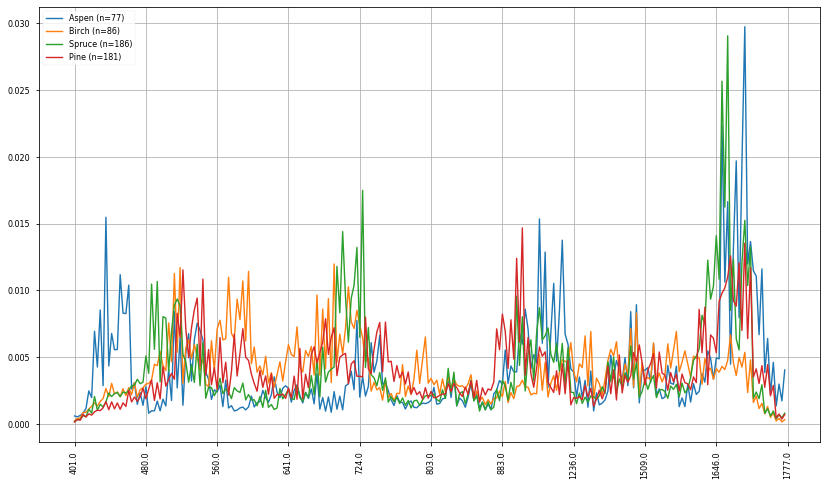

In [32]:
plt.figure(figsize=(14,8))
plt.plot(calc_l1_norm(aspen_saliences))
plt.plot(calc_l1_norm(birch_saliences))
plt.plot(calc_l1_norm(spruce_saliences))
plt.plot(calc_l1_norm(pine_saliences))
labels = [round(sel_bws[i],0) for i in np.arange(0, len(sel_bws), step=25)]
labels.append(round(sel_bws[-1],0))

plt.xticks(np.arange(0, len(sel_bws)+1, step=25), labels, rotation='vertical')
plt.grid()
plt.legend([f'Aspen (n={aspen_saliences.shape[0]})', f'Birch (n={birch_saliences.shape[0]})', 
            f'Spruce (n={spruce_saliences.shape[0]})', f'Pine (n={pine_saliences.shape[0]})',
           ])

And then class-wise most important bands:

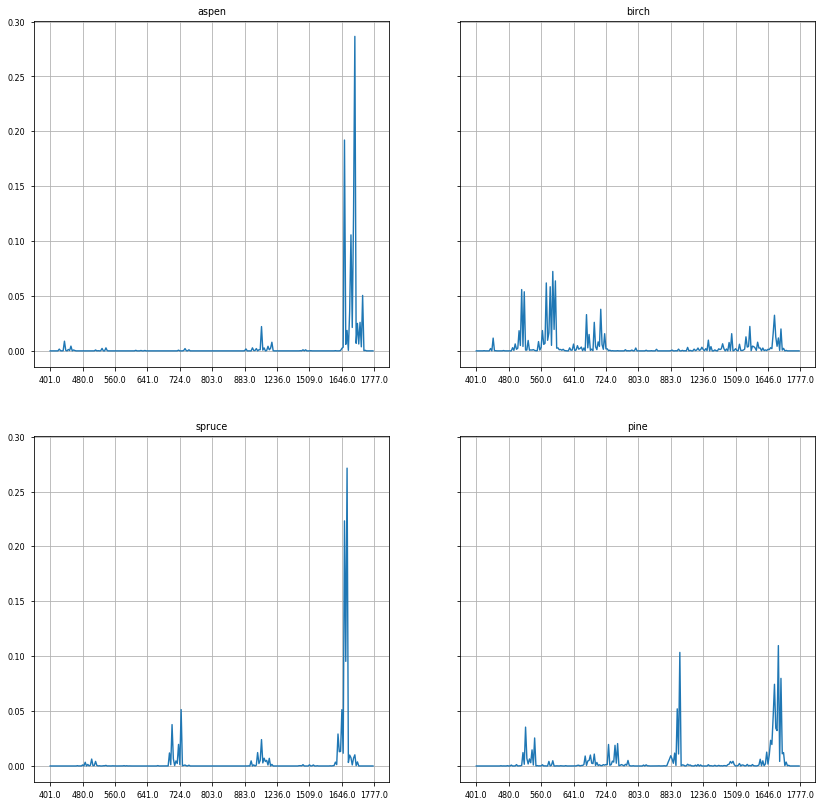

In [33]:
fig, axs = plt.subplots(2,2, figsize=(14,14), sharey=True)
for a in axs.flatten(): a.grid()
axs[0,0].plot(calc_important_bands(aspen_saliences))
axs[0,1].plot(calc_important_bands(birch_saliences))
axs[1,0].plot(calc_important_bands(spruce_saliences))
axs[1,1].plot(calc_important_bands(pine_saliences))
labels = [round(sel_bws[i],0) for i in np.arange(0, len(sel_bws), step=25)]
labels.append(round(sel_bws[-1], 0))
species = ['aspen', 'birch', 'spruce', 'pine']
for i, a in enumerate(axs.flatten()): a.set_title(species[i])
for a in axs.flatten():
    a.set_xticks(np.arange(0, len(sel_bws)+1, step=25))
    a.set_xticklabels(labels)

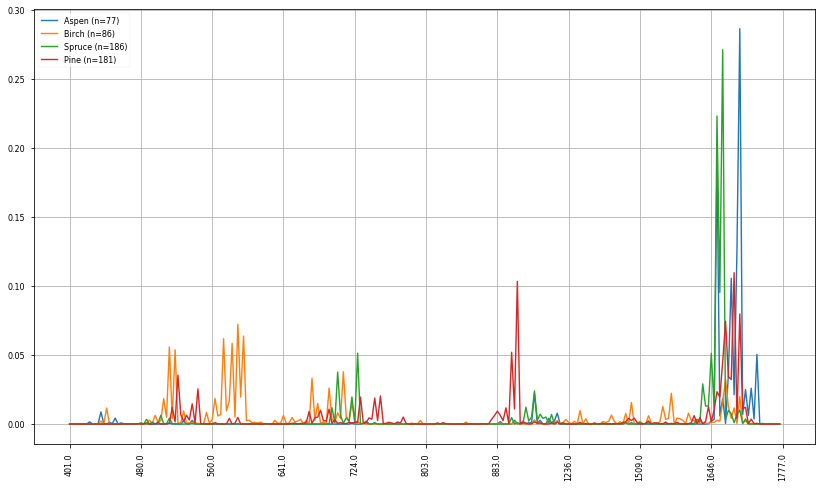

In [34]:
plt.figure(figsize=(14,8))
plt.plot(calc_important_bands(aspen_saliences))
plt.plot(calc_important_bands(birch_saliences))
plt.plot(calc_important_bands(spruce_saliences))
plt.plot(calc_important_bands(pine_saliences))
labels = [round(sel_bws[i],0) for i in np.arange(0, len(sel_bws), step=25)]
labels.append(round(sel_bws[-1],0))

plt.xticks(np.arange(0, len(sel_bws)+1, step=25), labels, rotation='vertical')
plt.grid()
plt.legend([f'Aspen (n={aspen_saliences.shape[0]})', f'Birch (n={birch_saliences.shape[0]})', 
            f'Spruce (n={spruce_saliences.shape[0]})', f'Pine (n={pine_saliences.shape[0]})',
           ])

Finally average magnitude of gradients

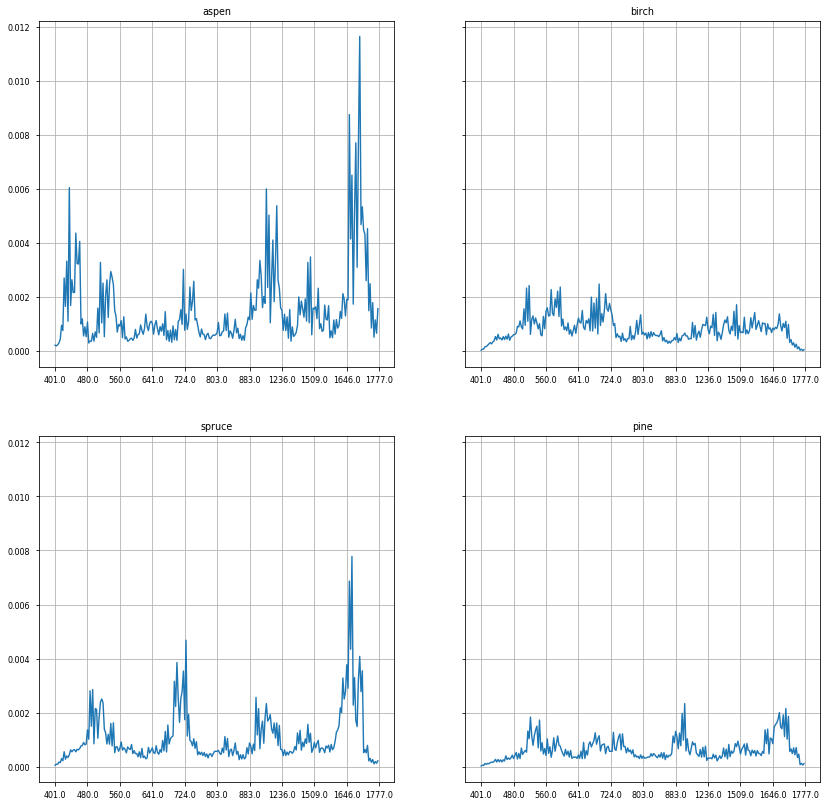

In [35]:
fig, axs = plt.subplots(2,2, figsize=(14,14), sharey=True)
for a in axs.flatten(): a.grid()
axs[0,0].plot(np.abs(aspen_saliences).mean(axis=(0,2,3)))
axs[0,1].plot(np.abs(birch_saliences).mean(axis=(0,2,3)))
axs[1,0].plot(np.abs(spruce_saliences).mean(axis=(0,2,3)))
axs[1,1].plot(np.abs(pine_saliences).mean(axis=(0,2,3)))
labels = [round(sel_bws[i],0) for i in np.arange(0, len(sel_bws), step=25)]
labels.append(round(sel_bws[-1], 0))
species = ['aspen', 'birch', 'spruce', 'pine']
for i, a in enumerate(axs.flatten()): a.set_title(species[i])
for a in axs.flatten():
    a.set_xticks(np.arange(0, len(sel_bws)+1, step=25))
    a.set_xticklabels(labels)

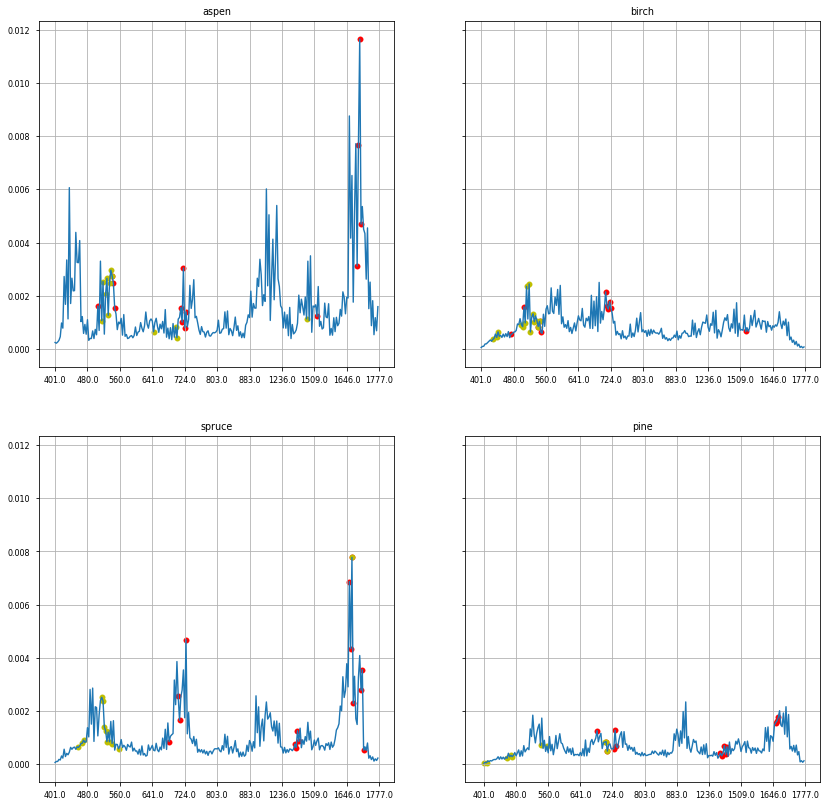

In [36]:
fig, axs = plt.subplots(2,2, figsize=(14,14), sharey=True)
for a in axs.flatten(): a.grid()
axs[0,0].plot(np.abs(aspen_saliences).mean(axis=(0,2,3)))
axs[0,0].scatter(svm_aspen_idx, [np.abs(aspen_saliences).mean(axis=(0,2,3))[i] for i in svm_aspen_idx], color='r')
axs[0,0].scatter(rf_aspen_idx, [np.abs(aspen_saliences).mean(axis=(0,2,3))[i] for i in rf_aspen_idx], color='y')

axs[0,1].plot(np.abs(birch_saliences).mean(axis=(0,2,3)))
axs[0,1].scatter(svm_birch_idx, [np.abs(birch_saliences).mean(axis=(0,2,3))[i] for i in svm_birch_idx], color='r')
axs[0,1].scatter(rf_birch_idx, [np.abs(birch_saliences).mean(axis=(0,2,3))[i] for i in rf_birch_idx], color='y')


axs[1,0].plot(np.abs(spruce_saliences).mean(axis=(0,2,3)))
axs[1,0].scatter(svm_spruce_idx, [np.abs(spruce_saliences).mean(axis=(0,2,3))[i] for i in svm_spruce_idx], color='r')
axs[1,0].scatter(rf_spruce_idx, [np.abs(spruce_saliences).mean(axis=(0,2,3))[i] for i in rf_spruce_idx], color='y')


axs[1,1].plot(np.abs(pine_saliences).mean(axis=(0,2,3)))
axs[1,1].scatter(svm_pine_idx, [np.abs(pine_saliences).mean(axis=(0,2,3))[i] for i in svm_pine_idx], color='r')
axs[1,1].scatter(rf_pine_idx, [np.abs(pine_saliences).mean(axis=(0,2,3))[i] for i in rf_pine_idx], color='y')


labels = [round(sel_bws[i],0) for i in np.arange(0, len(sel_bws), step=25)]
labels.append(round(sel_bws[-1], 0))
species = ['aspen', 'birch', 'spruce', 'pine']
for i, a in enumerate(axs.flatten()): a.set_title(species[i])
for a in axs.flatten():
    a.set_xticks(np.arange(0, len(sel_bws)+1, step=25))
    a.set_xticklabels(labels)

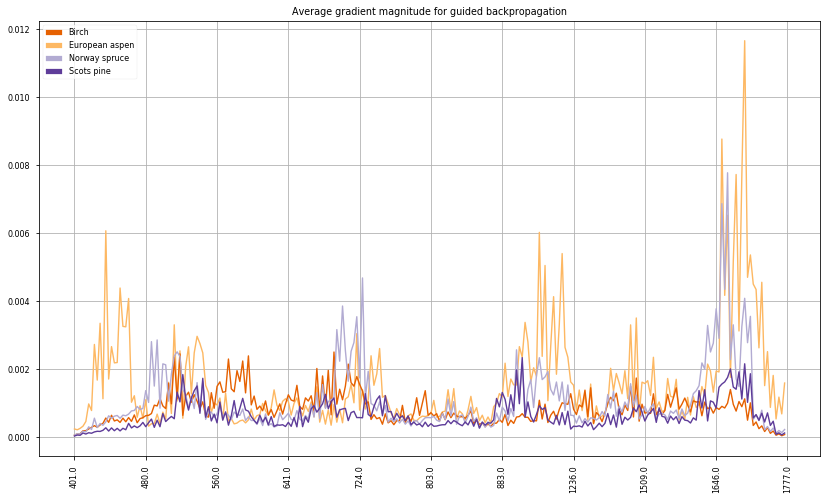

In [37]:
fig = plt.figure(figsize=(14,8))
plt.plot(np.abs(aspen_saliences).mean(axis=(0,2,3)), color="#fdb863")
plt.plot(np.abs(birch_saliences).mean(axis=(0,2,3)), color="#e66101")
plt.plot(np.abs(spruce_saliences).mean(axis=(0,2,3)), color="#b2abd2")
plt.plot(np.abs(pine_saliences).mean(axis=(0,2,3)), color="#5e3c99")
labels = [round(sel_bws[i],0) for i in np.arange(0, len(sel_bws), step=25)]
labels.append(round(sel_bws[-1],0))

plt.xticks(np.arange(0, len(sel_bws)+1, step=25), labels, rotation='vertical')
plt.grid()
birch_patch = mpatches.Patch(color='#e66101', label='Birch')
aspen_patch = mpatches.Patch(color='#fdb863', label='European aspen')
spruce_patch = mpatches.Patch(color='#b2abd2', label='Norway spruce')
pine_patch = mpatches.Patch(color='#5e3c99', label='Scots pine')
plt.legend(handles=[birch_patch, aspen_patch, spruce_patch, pine_patch])

plt.title('Average gradient magnitude for guided backpropagation')
plt.show()
#fig.savefig('guided_backprop_fixed.jpeg', dpi=500, bbox_inches='tight')

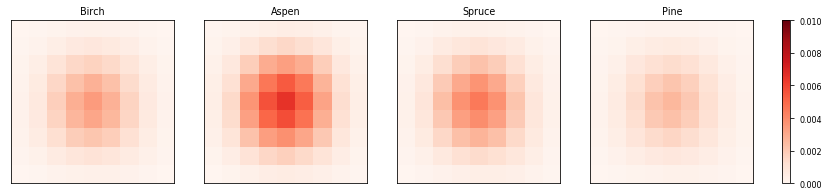

In [38]:
fig, axs = plt.subplots(1,5, figsize=(14,3), gridspec_kw={'width_ratios':[1,1,1,1,0.05]})
for a in axs[:-1].flatten():
    a.set_xticks([])
    a.set_yticks([])
    
vmin = 0
vmax = 0.01
im1 = axs[0].imshow(np.abs(birch_saliences).mean(axis=(0,1)), cmap='Reds', vmin=vmin, vmax=vmax)
axs[0].set_title('Birch')
axs[1].imshow(np.abs(aspen_saliences).mean(axis=(0,1)), cmap='Reds', vmin=vmin, vmax=vmax)
axs[1].set_title('Aspen')
axs[2].imshow(np.abs(spruce_saliences).mean(axis=(0,1)), cmap='Reds', vmin=vmin, vmax=vmax)
axs[2].set_title('Spruce')
axs[3].imshow(np.abs(pine_saliences).mean(axis=(0,1)), cmap='Reds', vmin=vmin, vmax=vmax)
axs[3].set_title('Pine')


cbar = fig.colorbar(im1, cax=axs[4])
#fig.savefig('spatial_occlusion_importances.jpeg', dpi=500, bbox_inches='tight')

Check spatial location importances:

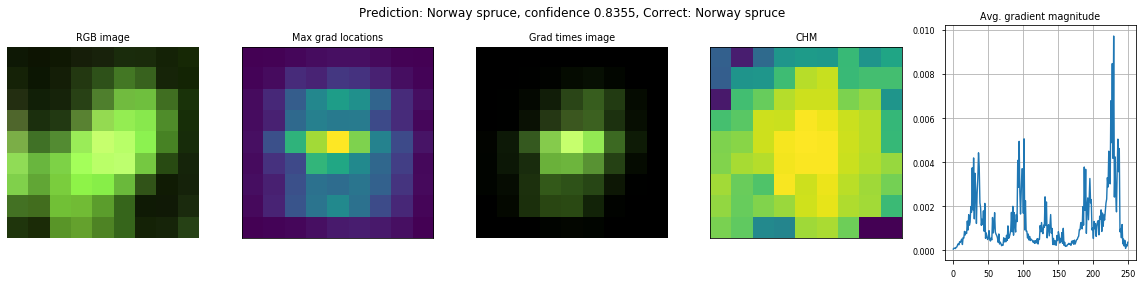

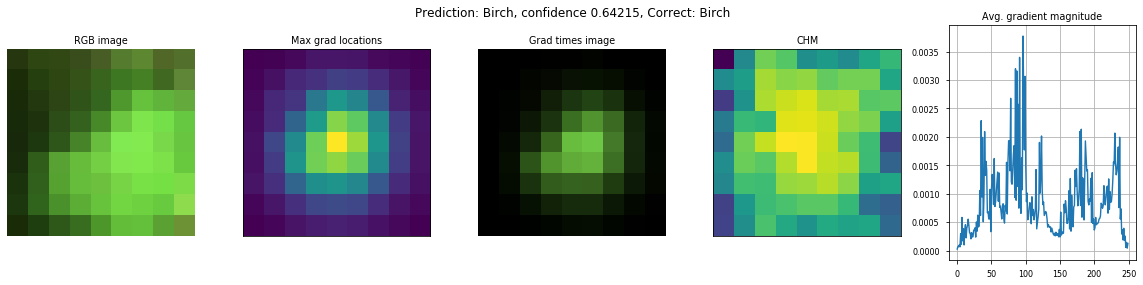

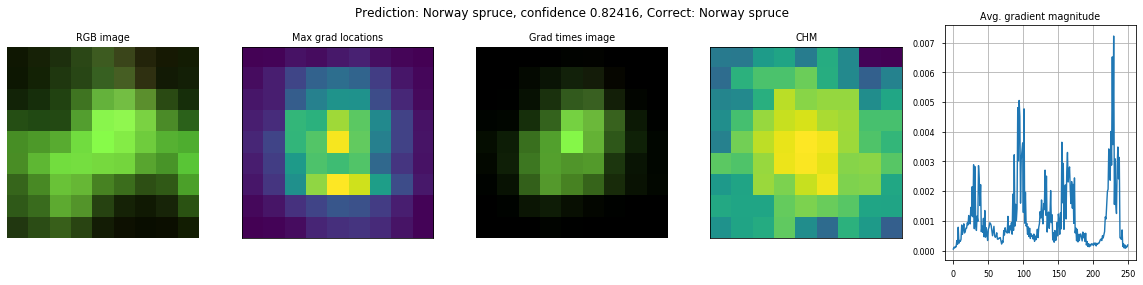

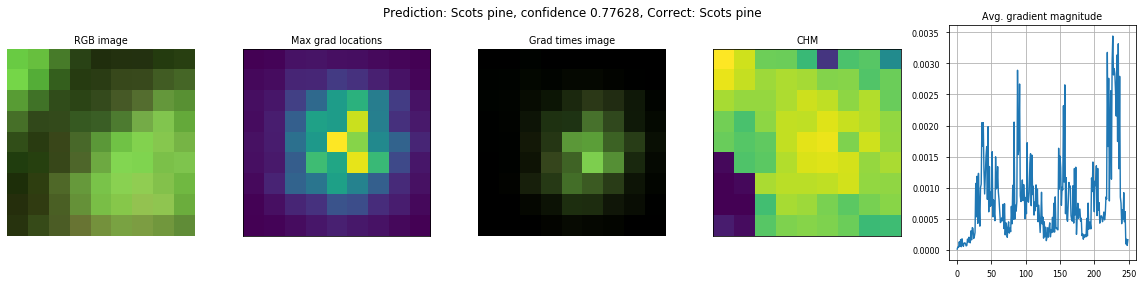

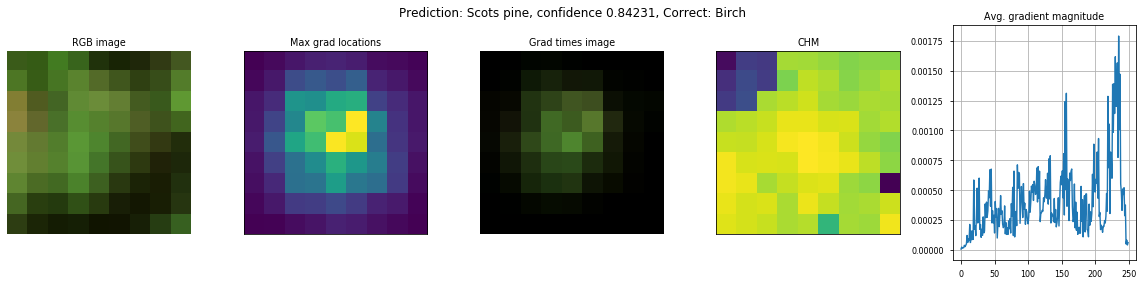

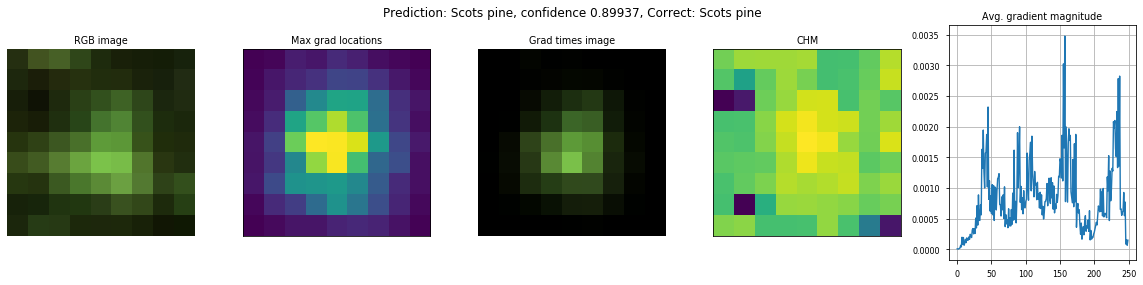

In [39]:
vmin, vmax = (0.05222363963723183, 5.074245080947874)

for im_idx in im_idx_list:
    fig, axs = plt.subplots(1,5, figsize=(16,4))
    imvals = MultiChannelTensorImage(all_valids[im_idx][0][0].cpu()*(stats[1][used_band_idxs,None, None])
                                     + (stats[0][used_band_idxs,None, None]))

    imvals.show(channels=[82,50,29], scale=True, scale_axis=None, 
                vmin=vmin, vmax=vmax, ax=axs[0])
    for a in axs[:-1]:
        a.set_xticks([])
        a.set_yticks([])
    axs[0].set_title('RGB image')
    axs[1].imshow(take_max_grad(all_saliences[im_idx]), vmin=0, vmax=1)
    axs[1].set_title('Max grad locations')
    grad_times_image = MultiChannelTensorImage((all_valids[im_idx][0][0].cpu()*stats[1][used_band_idxs,None, None] 
                                                + stats[0][used_band_idxs,None, None]) 
                                               * take_max_grad(all_saliences[im_idx]))
    grad_times_image.show(channels=[82,50,29], scale=True, scale_axis=None, 
                          vmin=vmin, vmax=vmax, ax=axs[2])
    axs[2].set_title('Grad times image')
    chm = np.load(str(data_path/test_dl.items.iloc[im_idx].filename))[-1]
    axs[3].imshow(chm / chm.max())
    axs[3].set_title('CHM')
    
    axs[4].plot(np.abs(all_saliences[im_idx]).mean(axis=(-2,-1)))
    axs[4].grid(True)
    axs[4].set_title('Avg. gradient magnitude')
    correct = test_dl.items.iloc[im_idx].species
    prediction = test_dl.vocab[test_preds[2][im_idx]]
    plt.tight_layout()
    plt.suptitle(f'Prediction: {prediction}, confidence {round(test_preds[0][im_idx].max().item(), 5)}, Correct: {correct}')

And let's look at the magnitude of the gradient for each spectral channel of last image separately.

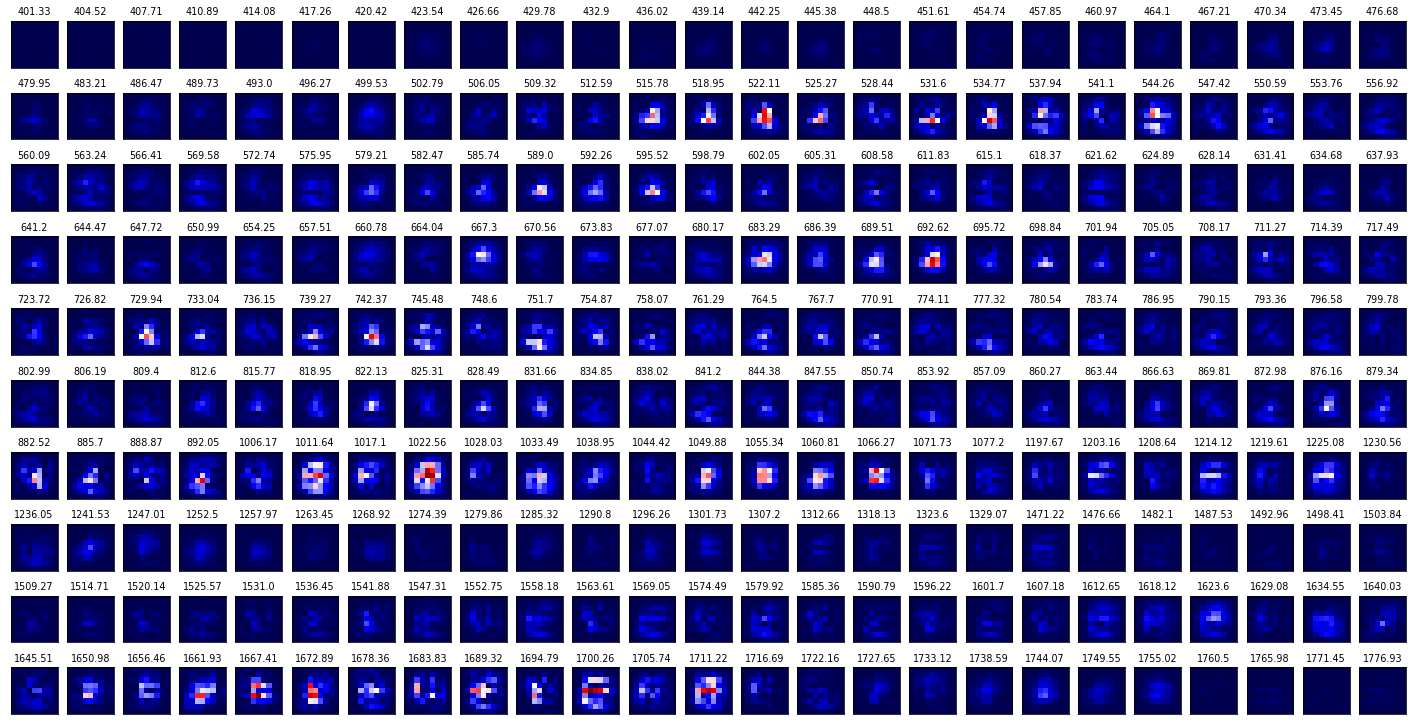

In [40]:
fig, axs = plt.subplots(10,25, figsize=(25,13))
for a in axs.flatten():
    a.set_xticks([])
    a.set_yticks([])
    
for i, ax in enumerate(axs.flatten()):
    ax.imshow(np.abs(all_saliences[im_idx][i]), vmin=0, vmax=np.abs(all_saliences[im_idx]).max(), cmap='seismic')
    ax.set_title(round(sel_bws[i], 2))


Here without taking the absolute value, but rather checking positive and negative input separately.

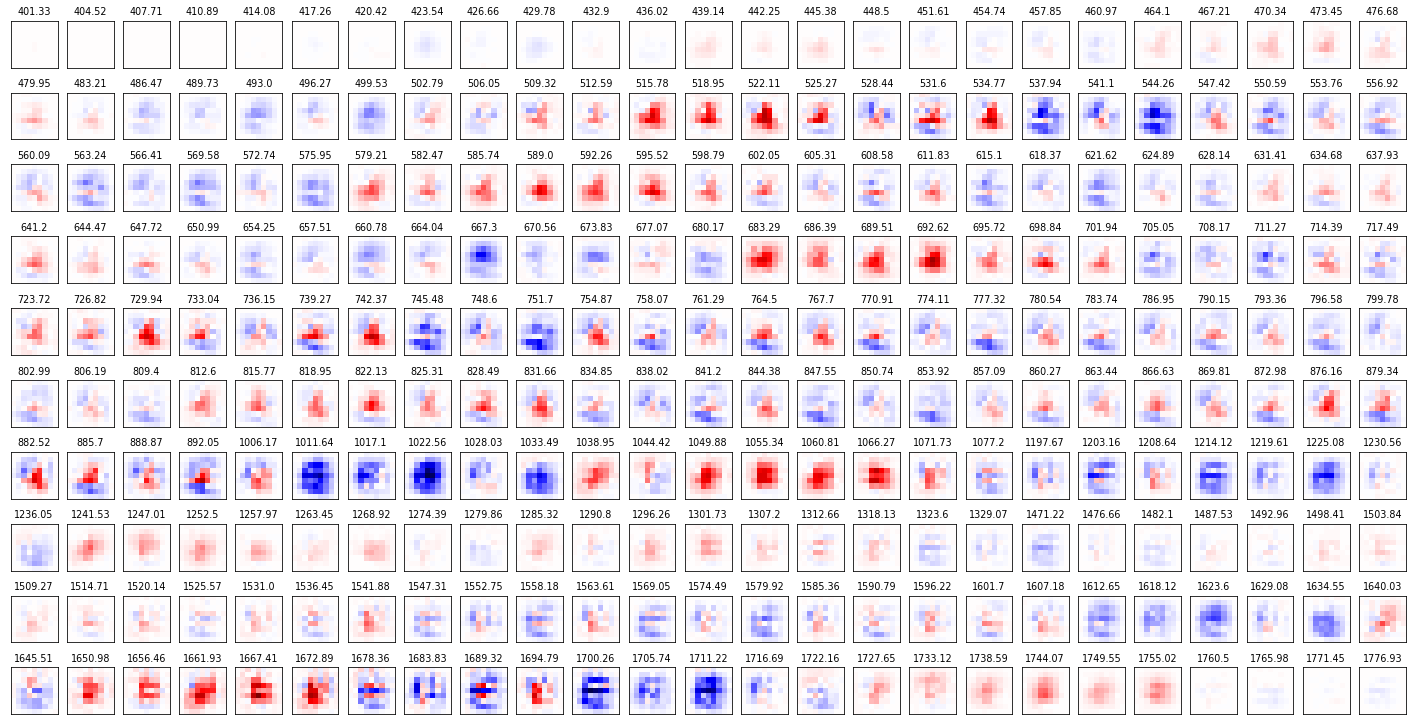

In [41]:
fig, axs = plt.subplots(10,25, figsize=(25,13))
for a in axs.flatten():
    a.set_xticks([])
    a.set_yticks([])
    
for i, ax in enumerate(axs.flatten()):
    ax.imshow((all_saliences[im_idx][i]), vmin=all_saliences[im_idx].min(), vmax=all_saliences[im_idx].max(), cmap='seismic')
    ax.set_title(round(sel_bws[i], 2))
#plt.tight_layout()

# Saliency via Occlusion

Mask a part of the image before feeding to CNN, check how much predicted probabilities change. Can be done in spectral or spatial dimension.

In [42]:
model = deepcopy(learn.model)

In [44]:
gpustats = tensor(stats[:,used_band_idxs]).cuda()

In [45]:
def normalize(inputs, stats):
    return (inputs - stats[0][:,None,None]) / stats[1][:,None,None]
    
def denormalize(inputs, stats):
    return inputs * stats[1][:,None,None] + stats[0][:,None,None]

def softmax(logits):
    return np.exp(logits) / np.sum(np.exp(logits), axis=0)

def spatial_occlusion(model, inputs):
    raw_outp = model(inputs).detach().cpu().numpy()[0]
    probas = softmax(raw_outp)
    correct = probas.argmax()
    max_proba = probas.max()
    changes = []
    for x, y in product(range(inputs.shape[-2]), range(inputs.shape[-1])):
        temp = deepcopy(inputs)
        # We have to do denorm->zero->norm here if we want to replace values with raw zero, because inputs are already normalized
        # Otherwise zero is the mean for training data
        #temp = denormalize(temp, stats)
        temp[:,:,:,x,y] = 0#torch.rand((inputs.shape[-3])).cuda() * 2 - 1
        #temp = normalize(temp, stats)
        occ_outp = model(temp).detach().cpu().numpy()[0]
        probas = softmax(occ_outp)
        occ_max = probas[correct]
        changes.append((x,y,occ_max-max_proba))
    return changes
    
def spectral_occlusion(model, inputs):
    raw_outp = model(inputs).detach().cpu().numpy()[0]
    probas = softmax(raw_outp)
    correct = probas.argmax()
    max_proba = probas.max()
    changes = []
    for c in range(inputs.shape[-3]):
        temp = deepcopy(inputs)
        # We have to do denorm->zero->norm here
        #temp = denormalize(temp, stats)
        temp[:,:,c] = 0#torch.rand((inputs.shape[-1], inputs.shape[-1])).cuda() * 2 - 1
        #temp = normalize(temp, stats)
        occ_outp = model(temp).detach().cpu().numpy()[0]
        probas = softmax(occ_outp)
        occ_max = probas[correct]
        changes.append((occ_max-max_proba))
    return changes

In [46]:
aspen_valids = np.array(valids[1])
birch_valids = np.array(valids[0])
spruce_valids = np.array(valids[2])
pine_valids = np.array(valids[3])

In [47]:
aspen_spectral_changes = []
for v in aspen_valids:
    aspen_spectral_changes.append(spectral_occlusion(model, v))

In [48]:
birch_spectral_changes = []
for v in birch_valids:
    birch_spectral_changes.append(spectral_occlusion(model, v))

In [49]:
spruce_spectral_changes = []
for v in spruce_valids:
    spruce_spectral_changes.append(spectral_occlusion(model, v))

In [50]:
pine_spectral_changes = []
for v in pine_valids:
    pine_spectral_changes.append(spectral_occlusion(model, v))

Text(0.5, 0.98, 'Average probability change of initially predicted class when masking out spectral band')

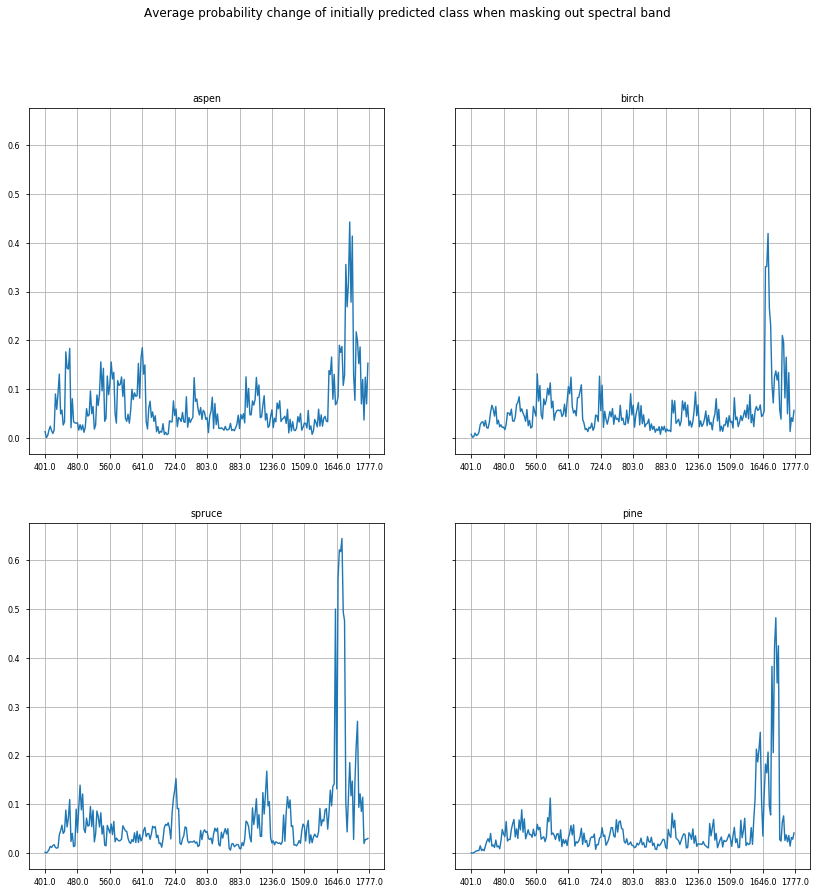

In [51]:
fig, axs = plt.subplots(2,2, figsize=(14,14), sharey=True)
for a in axs.flatten(): a.grid()
axs[0,0].plot(np.array(np.abs(aspen_spectral_changes)).mean(axis=0))
axs[0,1].plot(np.array(np.abs(birch_spectral_changes)).mean(axis=0))
axs[1,0].plot(np.array(np.abs(spruce_spectral_changes)).mean(axis=0))
axs[1,1].plot(np.array(np.abs(pine_spectral_changes)).mean(axis=0))
labels = [round(sel_bws[i],0) for i in np.arange(0, len(sel_bws), step=25)]
labels.append(round(sel_bws[-1],0))
species = ['aspen', 'birch', 'spruce', 'pine']
for i, a in enumerate(axs.flatten()): a.set_title(species[i])
for a in axs.flatten():
    a.set_xticks(np.arange(0, len(sel_bws)+1, step=25))
    a.set_xticklabels(labels)
plt.suptitle('Average probability change of initially predicted class when masking out spectral band')

Text(0.5, 0.98, 'Average probability change of initially predicted class when masking out spectral band')

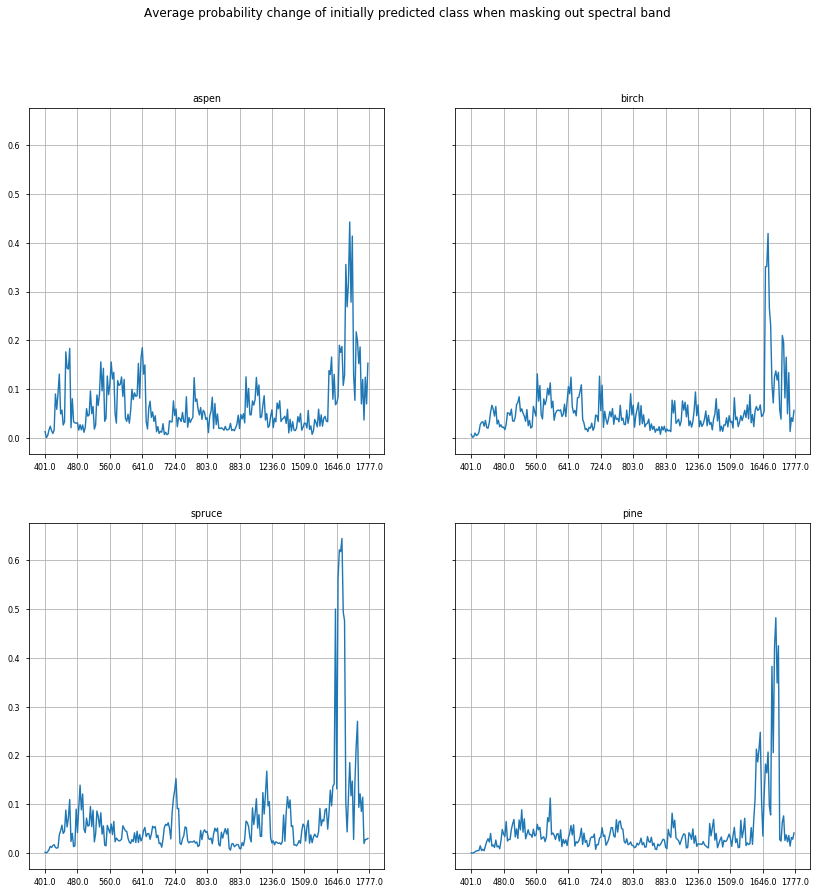

In [52]:
fig, axs = plt.subplots(2,2, figsize=(14,14), sharey=True)
for a in axs.flatten(): a.grid()
axs[0,0].plot(np.array(np.abs(aspen_spectral_changes)).mean(axis=0))
axs[0,1].plot(np.array(np.abs(birch_spectral_changes)).mean(axis=0))
axs[1,0].plot(np.array(np.abs(spruce_spectral_changes)).mean(axis=0))
axs[1,1].plot(np.array(np.abs(pine_spectral_changes)).mean(axis=0))
labels = [round(sel_bws[i],0) for i in np.arange(0, len(sel_bws), step=25)]
labels.append(round(sel_bws[-1],0))
species = ['aspen', 'birch', 'spruce', 'pine']
for i, a in enumerate(axs.flatten()): a.set_title(species[i])
for a in axs.flatten():
    a.set_xticks(np.arange(0, len(sel_bws)+1, step=25))
    a.set_xticklabels(labels)
plt.suptitle('Average probability change of initially predicted class when masking out spectral band')

Text(0.5, 0.98, 'Average probability change of initially predicted class when masking out spectral band')

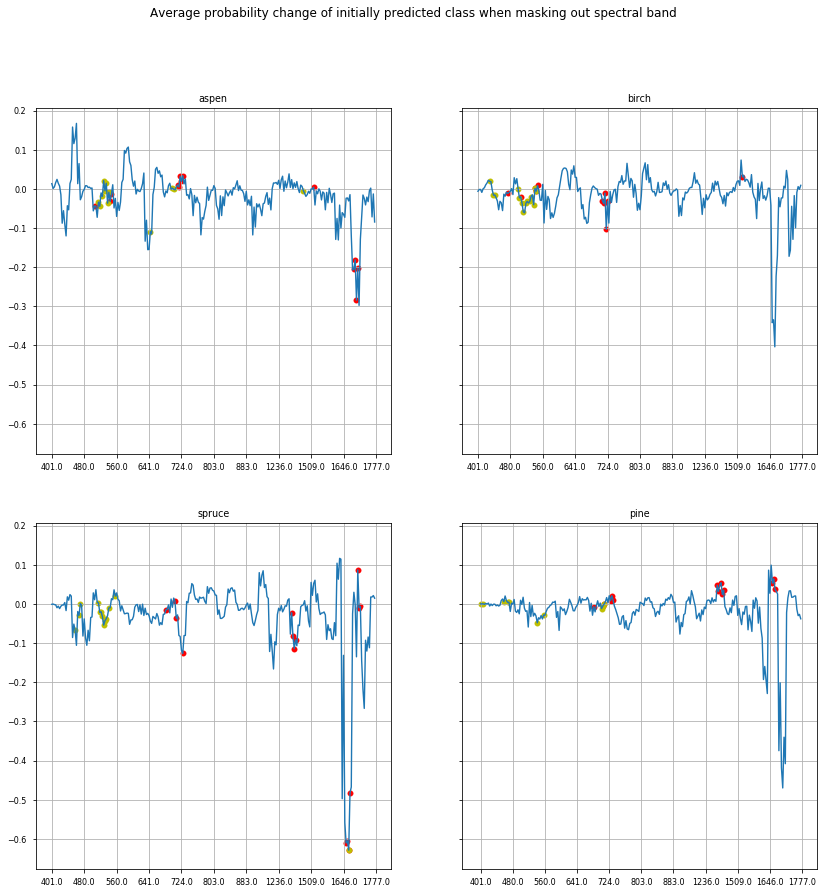

In [53]:
fig, axs = plt.subplots(2,2, figsize=(14,14), sharey=True)
for a in axs.flatten(): a.grid()
axs[0,0].plot(np.array(aspen_spectral_changes).mean(axis=0))
axs[0,0].scatter(svm_aspen_idx, [np.array(aspen_spectral_changes).mean(axis=0)[i] for i in svm_aspen_idx], color='r')
axs[0,0].scatter(rf_aspen_idx, [np.array(aspen_spectral_changes).mean(axis=0)[i] for i in rf_aspen_idx], color='y')

axs[0,1].plot(np.array(birch_spectral_changes).mean(axis=0))
axs[0,1].scatter(svm_birch_idx, [np.array(birch_spectral_changes).mean(axis=0)[i] for i in svm_birch_idx], color='r')
axs[0,1].scatter(rf_birch_idx, [np.array(birch_spectral_changes).mean(axis=0)[i] for i in rf_birch_idx], color='y')

axs[1,0].plot(np.array(spruce_spectral_changes).mean(axis=0))
axs[1,0].scatter(svm_spruce_idx, [np.array(spruce_spectral_changes).mean(axis=0)[i] for i in svm_spruce_idx], color='r')
axs[1,0].scatter(rf_spruce_idx, [np.array(spruce_spectral_changes).mean(axis=0)[i] for i in rf_spruce_idx], color='y')

axs[1,1].plot(np.array(pine_spectral_changes).mean(axis=0))
axs[1,1].scatter(svm_pine_idx, [np.array(pine_spectral_changes).mean(axis=0)[i] for i in svm_pine_idx], color='r')
axs[1,1].scatter(rf_pine_idx, [np.array(pine_spectral_changes).mean(axis=0)[i] for i in rf_pine_idx], color='y')

labels = [round(sel_bws[i],0) for i in np.arange(0, len(sel_bws), step=25)]
labels.append(round(sel_bws[-1],0))
species = ['aspen', 'birch', 'spruce', 'pine']
for i, a in enumerate(axs.flatten()): a.set_title(species[i])
for a in axs.flatten():
    a.set_xticks(np.arange(0, len(sel_bws)+1, step=25))
    a.set_xticklabels(labels)
plt.suptitle('Average probability change of initially predicted class when masking out spectral band')

In [54]:
from sklearn.metrics import accuracy_score

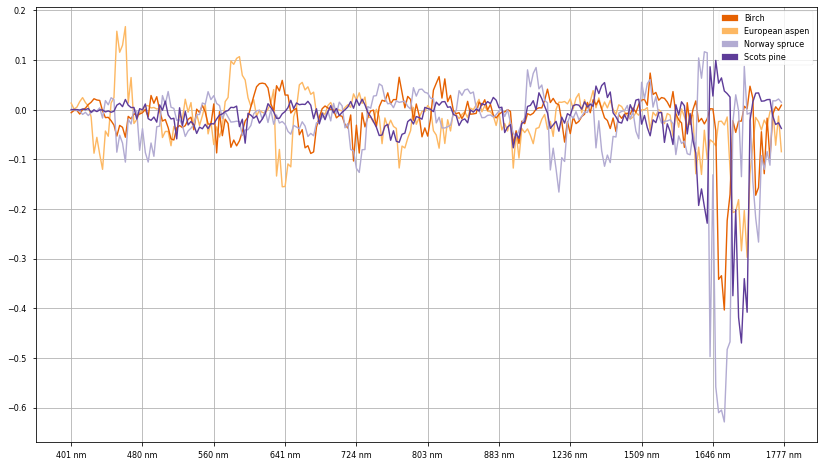

In [55]:
fig = plt.figure(figsize=(14,8))
plt.plot(np.array(aspen_spectral_changes).mean(axis=0), color='#fdb863')
plt.plot(np.array(birch_spectral_changes).mean(axis=0), color='#e66101')
plt.plot(np.array(spruce_spectral_changes).mean(axis=0), color='#b2abd2')
plt.plot(np.array(pine_spectral_changes).mean(axis=0), color='#5e3c99')
labels = [f'{int(round(sel_bws[i],0))} nm' for i in np.arange(0, len(sel_bws), step=25)]
labels.append(f'{int(round(sel_bws[-1],0))} nm')

plt.xticks(np.arange(0, len(sel_bws)+1, step=25), labels, rotation='horizontal')
plt.grid()
birch_patch = mpatches.Patch(color='#e66101', label='Birch')
aspen_patch = mpatches.Patch(color='#fdb863', label='European aspen')
spruce_patch = mpatches.Patch(color='#b2abd2', label='Norway spruce')
pine_patch = mpatches.Patch(color='#5e3c99', label='Scots pine')
plt.legend(handles=[birch_patch, aspen_patch, spruce_patch, pine_patch])
#plt.title('Average probability change of initially predicted class when masking out spectral band')
plt.show()
#fig.savefig('occlusion_importances_fixed.jpeg', dpi=500, bbox_inches='tight')

In [56]:
aspen_spatial_changes = []
for v in aspen_valids:
    aspen_spatial_changes.append(spatial_occlusion(model, v))

In [57]:
birch_spatial_changes = []
for v in birch_valids:
    birch_spatial_changes.append(spatial_occlusion(model, v))

In [58]:
spruce_spatial_changes = []
for v in spruce_valids:
    spruce_spatial_changes.append(spatial_occlusion(model, v))

In [59]:
pine_spatial_changes = []
for v in pine_valids:
    pine_spatial_changes.append(spatial_occlusion(model, v))

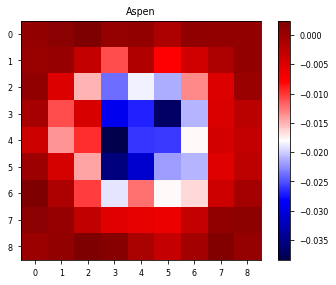

In [60]:
heatmaps = []
for stat in aspen_spatial_changes:
    heatmap = np.zeros((aspen_valids[0].shape[-2], aspen_valids[0].shape[-1]))
    for val in stat:
        x,y,change = val
        heatmap[x,y] = change
    heatmaps.append(heatmap)
plt.imshow(np.array(heatmaps).mean(axis=(0)), cmap='seismic')
plt.colorbar()
plt.title('Aspen')
plt.show()

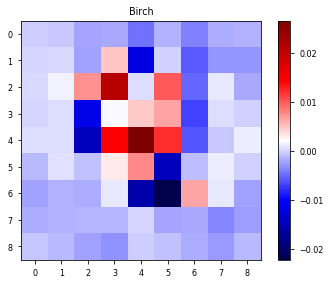

In [61]:
heatmaps = []
for stat in birch_spatial_changes:
    heatmap = np.zeros((aspen_valids[0].shape[-2], aspen_valids[0].shape[-1]))
    for val in stat:
        x,y,change = val
        heatmap[x,y] = change
    heatmaps.append(heatmap)
plt.imshow(np.array(heatmaps).mean(axis=(0)), cmap='seismic')
plt.colorbar()
plt.title('Birch')

plt.show()

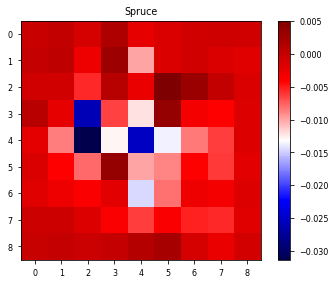

In [62]:
heatmaps = []
for stat in spruce_spatial_changes:
    heatmap = np.zeros((aspen_valids[0].shape[-2], aspen_valids[0].shape[-1]))
    for val in stat:
        x,y,change = val
        heatmap[x,y] = change
    heatmaps.append(heatmap)
plt.imshow(np.array(heatmaps).mean(axis=(0)), cmap='seismic')
plt.colorbar()
plt.title('Spruce')

plt.show()

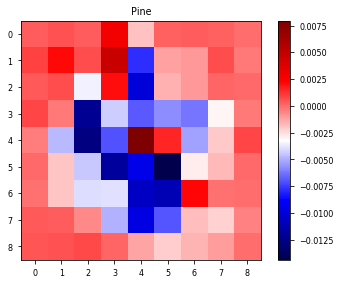

In [63]:
heatmaps = []
for stat in pine_spatial_changes:
    heatmap = np.zeros((aspen_valids[0].shape[-2], aspen_valids[0].shape[-1]))
    for val in stat:
        x,y,change = val
        heatmap[x,y] = change
    heatmaps.append(heatmap)
plt.imshow(np.array(heatmaps).mean(axis=(0)), cmap='seismic')
plt.colorbar()
plt.title('Pine')

plt.show()

In [64]:
def plot_hmap(vals, ax, vmin, vmax, title, cmap='seismic', shape=9):
    hmaps = []
    for stat in vals:
        hmap = np.zeros((shape, shape))
        for val in stat:
            x,y,change = val
            hmap[x,y] = change
        hmaps.append(hmap)
    im1 = ax.imshow(np.array(hmaps).mean(axis=(0)), cmap='seismic', vmin=vmin, vmax=vmax)
    ax.set_title(title)
    return im1

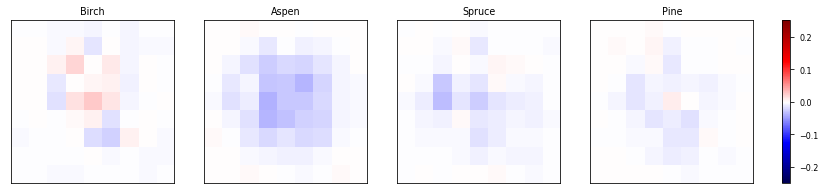

In [65]:
fig, axs = plt.subplots(1,5, figsize=(14,3), gridspec_kw={'width_ratios':[1,1,1,1,0.05]})
for a in axs[:-1].flatten():
    a.set_xticks([])
    a.set_yticks([])
    
vmin = -0.25
vmax = 0.25
im1 = plot_hmap(birch_spatial_changes, axs[0], vmin, vmax, 'Birch', shape=all_saliences[im_idx][i].shape[0])
plot_hmap(aspen_spatial_changes, axs[1], vmin, vmax, 'Aspen', shape=all_saliences[im_idx][i].shape[0])
plot_hmap(spruce_spatial_changes, axs[2], vmin, vmax, 'Spruce', shape=all_saliences[im_idx][i].shape[0])
plot_hmap(pine_spatial_changes, axs[3], vmin, vmax, 'Pine', shape=all_saliences[im_idx][i].shape[0])

cbar = fig.colorbar(im1, cax=axs[4])
#fig.savefig('spatial_occlusion_importances_fixed.jpeg', dpi=500, bbox_inches='tight')

In [66]:
def spectral_occlusion_class_probas(model, inputs):
    raw_outp = model(inputs).detach().cpu().numpy()[0]
    probas = softmax(raw_outp)
    correct = probas.argmax()
    changes = []
    for c in range(inputs.shape[-3]):
        temp = deepcopy(inputs)
        # We have to do denorm->zero->norm here
        #temp = denormalize(temp, stats)
        temp[:,:,c] = torch.rand((inputs.shape[-1], inputs.shape[-1])).cuda() * 2 - 1
        #temp = normalize(temp, stats)
        occ_outp = model(temp).detach().cpu().numpy()[0]
        #max_proba = softmax(occ_outp).argmax()
        changes.append(softmax(occ_outp))
    return changes

In [67]:
def spatial_occlusion_class(model, inputs):
    raw_outp = model(inputs).detach().cpu().numpy()[0]
    probas = softmax(raw_outp)
    correct = probas.argmax()
    changes = []
    for x, y in product(range(inputs.shape[-2]), range(inputs.shape[-1])):
        temp = deepcopy(inputs)
        # We have to do denorm->zero->norm here if we want to replace values with raw zero, because inputs are already normalized
        # Otherwise zero is the mean for training data
        #temp = denormalize(temp, stats)
        temp[:,:,:,x,y] = 0#torch.rand(inputs.shape[-3]).cuda() * 2 - 1
        #temp = normalize(temp, stats)
        occ_outp = model(temp).detach().cpu().numpy()[0]
        max_proba = softmax(occ_outp).argmax()
        changes.append((x,y,max_proba))
    return changes
    
def spectral_occlusion_class(model, inputs):
    raw_outp = model(inputs).detach().cpu().numpy()[0]
    probas = softmax(raw_outp)
    correct = probas.argmax()
    changes = []
    for c in range(inputs.shape[-3]):
        temp = deepcopy(inputs)
        # We have to do denorm->zero->norm here
        #temp = denormalize(temp, stats)
        temp[:,:,c] = 0#torch.rand((inputs.shape[-1], inputs.shape[-1])).cuda() * 2 - 1
        #temp = normalize(temp, stats)
        occ_outp = model(temp).detach().cpu().numpy()[0]
        max_proba = softmax(occ_outp).argmax()
        changes.append((max_proba))
    return changes

In [68]:
from matplotlib.colors import ListedColormap

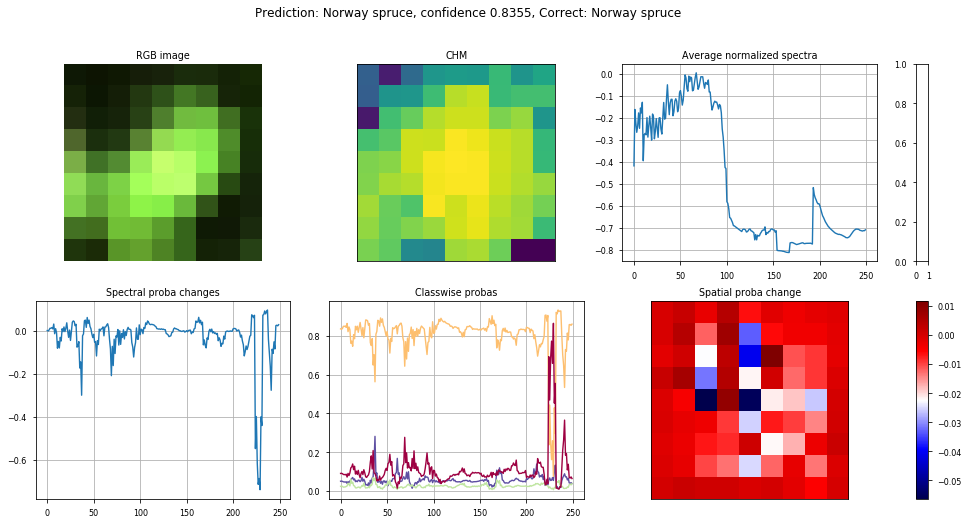

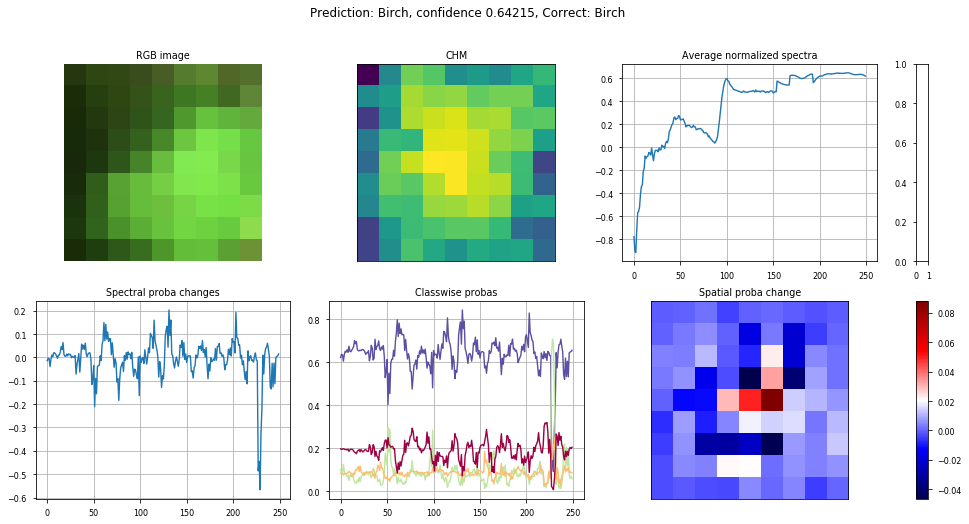

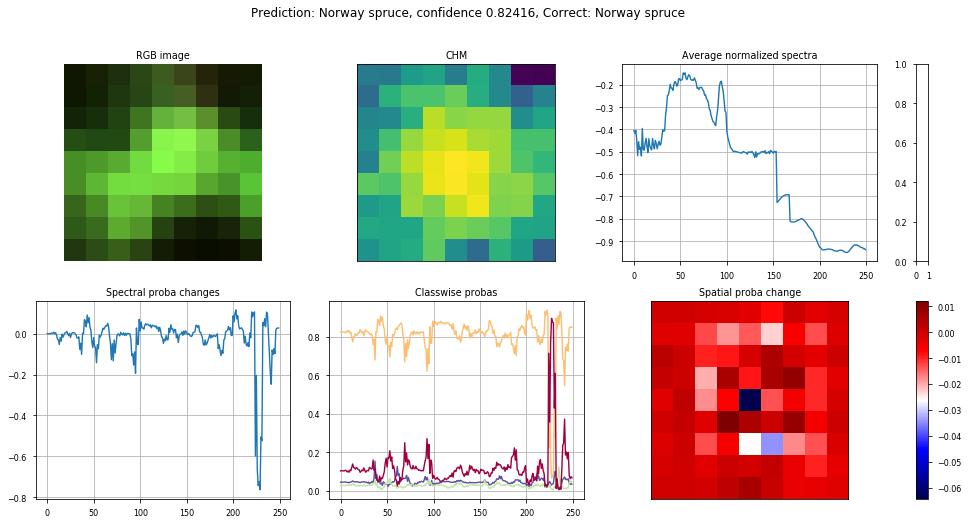

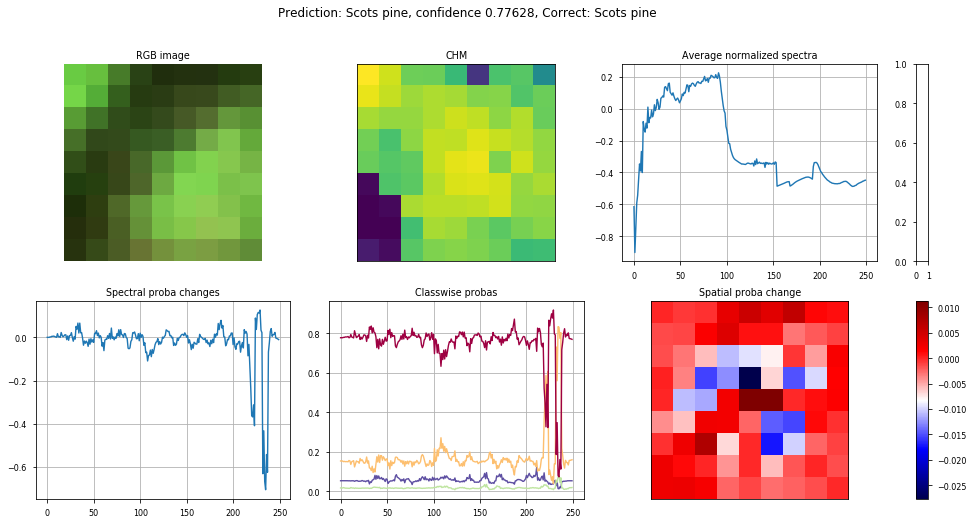

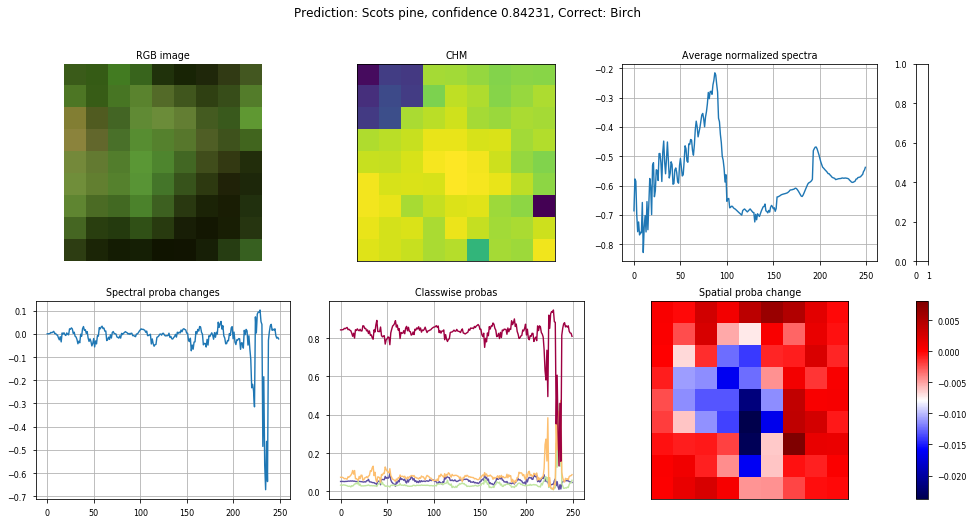

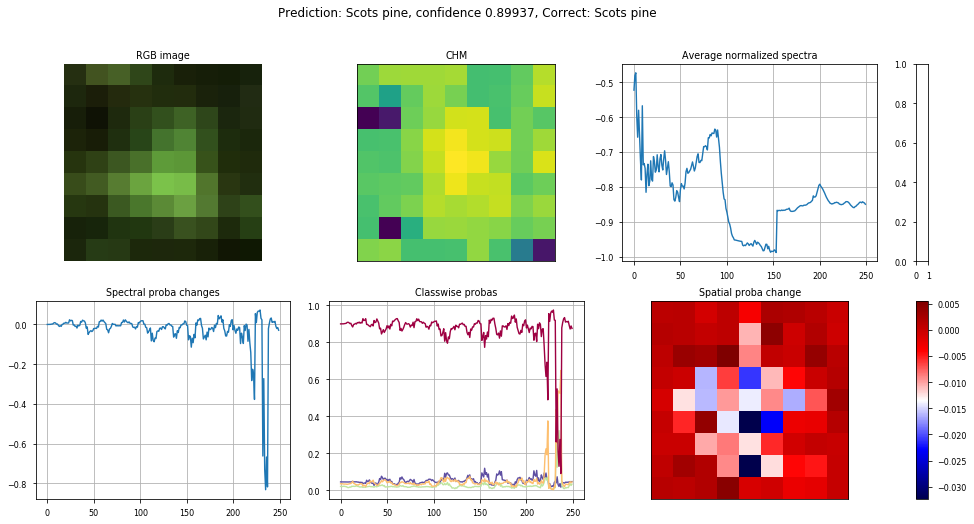

In [69]:
vmin, vmax = (0.05222363963723183, 5.074245080947874)

colormap = ListedColormap(plt.cm.Spectral(np.linspace(1,0,4)))

for im_idx in im_idx_list:
    fig, axs = plt.subplots(2,4, figsize=(16,8), gridspec_kw={'width_ratios': [1,1,1,0.05]})
    
    # RGB
    imvals = MultiChannelTensorImage(all_valids[im_idx][0][0].cpu()*(stats[1][used_band_idxs,None, None])
                                     + (stats[0][used_band_idxs,None, None]))

    imvals.show(channels=[82,50,29], scale=True, scale_axis=None, 
                vmin=vmin, vmax=vmax, ax=axs[0,0])
    for a in axs.flatten()[:2]:
        a.set_xticks([])
        a.set_yticks([])
    axs[0,0].set_title('RGB image')
    
    #CHM 
    chm = np.load(str(data_path/test_dl.items.iloc[im_idx].filename))[-1]
    axs[0,1].imshow(chm / chm.max())
    axs[0,1].set_title('CHM')

    # Average spectra
    norm_imvals = MultiChannelTensorImage(all_valids[im_idx][0][0].cpu())
    norm_imvals.show(channels='spectra', ax=axs[0,2])
    axs[0,2].set_title('Average normalized spectra')
    
    
    # Spatial proba changes
    spatial_proba_changes = spatial_occlusion(model, all_valids[im_idx])
    hmap = np.zeros((imvals.shape[-1], imvals.shape[-2]))
    for val in spatial_proba_changes:
        x,y,change = val
        hmap[x,y] = change
    axs[1,2].set_title('Spatial proba change')
    spat_probas = axs[1,2].imshow(hmap, cmap='seismic')
    axs[1,2].set_xticks([])
    axs[1,2].set_yticks([])
    # Spatial proba colorbar
    cbar = fig.colorbar(spat_probas, cax=axs[1,3])
    
    # Spectral proba changes
    spectral_proba_changes = spectral_occlusion(model, all_valids[im_idx])
    axs[1,0].plot(spectral_proba_changes)
    axs[1,0].grid(true)
    axs[1,0].set_title('Spectral proba changes')
    

    # Most common class spectral
    spectral_proba_classes = np.array(spectral_occlusion_class_probas(model, all_valids[im_idx]))
    for i in range(4):     
    #axs[1,1].scatter(np.arange(250), spectral_proba_classes, marker='.')
        axs[1,1].plot(np.array(spectral_proba_classes[:,i]), color=colormap.colors[i])
    axs[1,1].grid(True)
    axs[1,1].set_title('Classwise probas')
    #axs[1,1].set_yticks([0,1,2,3])
    #axs[1,1].set_yticklabels(['Birch', 'Aspen', 'Spruce', 'Pine'])
    
    # Most common class spatial
    #spatial_proba_classes = spatial_occlusion_class(model, all_valids[im_idx])
    #hmap = np.zeros((imvals.shape[-1], imvals.shape[-2]))
    #for val in spatial_proba_classes:
    #    x,y,change = val
    #    hmap[x,y] = change
    #axs[1,2].set_title('Predicted class spatial')
    #spat_classes = axs[1,2].imshow(hmap, cmap=colormap, vmin=0, vmax=3)
    #axs[1,2].set_xticks([])
    #axs[1,2].set_yticks([])
    # Spatial class colorbar
    #cbar_class = fig.colorbar(spat_classes, cax=axs[1,3], ticks=[0,1,2,3])
    #cbar_class.set_ticklabels(['Birch', 'Aspen', 'Spruce', 'Pine'])

    correct = test_dl.items.iloc[im_idx].species
    prediction = test_dl.vocab[test_preds[2][im_idx]]
    #plt.tight_layout()
    plt.suptitle(f'Prediction: {prediction}, confidence {round(test_preds[0][im_idx].max().item(), 5)}, Correct: {correct}')